## 꾸러미 가져오기
---
갑자기 영어로 된 표현이 맘에 안 들어서 제목을 바꿨습니다.
또한 폰트 설치도 여기서 했습니다.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import numpy as np
import tensorflow as tf
import sentencepiece as spm
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

In [2]:
!sudo apt -qq -y install fonts-nanum

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [3]:
%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

## 자료 가져오기, 중복제거
---

In [4]:
data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
work_dir = os.getenv('HOME')+'/aiffel/transformer/workdata'
kor_path = data_dir+"/korean-english-park.train.ko"
eng_path = data_dir+"/korean-english-park.train.en"
model_path = work_dir + '/model'

In [5]:
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: 
        kor = f.read().splitlines()
    with open(eng_path, "r") as f: 
        eng = f.read().splitlines()
    assert len(kor) == len(eng)

    raw = zip(kor, eng)
    cleaned_corpus = set(raw)

    return cleaned_corpus

In [6]:
cleaned_corpus = clean_corpus(kor_path, eng_path)
kor_corpus, eng_corpus = zip(*cleaned_corpus)
print(len(kor_corpus), len(eng_corpus))

78968 78968


In [7]:
idx = np.random.choice(len(kor_corpus), 50)
for i in idx:
    print(f'{i}')
    print(f'ko >>> {kor_corpus[i]}')
    print(f'en >>> {eng_corpus[i]}\n')

44517
ko >>> 법원은 동물보호 운동가로 활동 중인 브리짓 바르도에게 2만3325달러(약 2400만원)의 벌금형을 선고했다.
en >>> The court also handed down a $23,325 fine against the former screen siren and animal rights campaigner.

26736
ko >>> 도디의 부친 모하메드 알 파예드는 자신이 소유한 해로즈 백화점에서 2분간 묵념하며 아들을 추모했다.
en >>> Dodi's father Mohamed al Fayed held two minutes' silence in honor of his son and the princess at his Harrods store in Knightsbridge, London.

9117
ko >>> 70 처녀좌 주변의 행성은 특히 중요다고 볼티모어에 있는 우주 망원경 과학 연구소의 행성계 전문가인 로버트 브라운은 말한다.
en >>> The planet around 70 Virginis is particularly important, observes Robert Brown, a planetary systems specialist at the Space Telescope Science Institute in Baltimore.

17154
ko >>> 파키스탄 경찰은 당국에서 반정부 단체의 지도자인 나와즈 샤리프를 유치시키려고 하자 돌을 던지며 시위하는 시위자들에게 최루탄을 발포했습니다.
en >>> Police in Pakistan fired tear gas at stone-throwing protesters after authorities tried to detain the opposition leader Nawaz Sharif.

47539
ko >>> 버나드가 스크린에 빨간색, 파란색, 노란색 그림을 그리고 있을 때 제리 맥카씨는 그의 딸에게 “대단하다”고 말했다.
en >>> "That's so cool," Jeri 

## 자료 정제 및 조각화(tokenize)
---

In [8]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅣ가-힣?.!,]+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

In [9]:
def generate_tokenizer(corpus,
                        vocab_size=20000,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    corpus_path = f'{work_dir}/sp_train_corpus_{lang}.temp'
    with open(corpus_path, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')

    prefix = f'{model_path}/spm_{lang}'
    
    spm.SentencePieceTrainer.Train(
        f'--input={corpus_path} \
            --model_prefix={prefix} \
            --vocab_size={vocab_size} \
            --model_type=unigram \
            --pad_id={pad_id} \
            --bos_id={bos_id} \
            --eos_id={eos_id} \
            --unk_id={unk_id}')
    
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{prefix}.model')

    return tokenizer

In [10]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair
#     print(k)

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [12]:
src_corpus = []
tgt_corpus = []
max_len = 50

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm_notebook(range(len(kor_corpus))):
    ko_tokenized = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    en_tokenized = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(ko_tokenized) <= max_len and len(en_tokenized) <= max_len:
        src_corpus.append(ko_tokenized)
        tgt_corpus.append(en_tokenized)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/78968 [00:00<?, ?it/s]

In [13]:
len(enc_train), len(dec_train)

(67815, 67815)

In [14]:
idx = np.random.choice(len(enc_train), 3)

In [15]:
for i in idx:
    print(i)
    print(f'ko encoded : {enc_train[i]}')
    print(f'ko decoded : {ko_tokenizer.DecodeIds(enc_train[i].tolist())}')
    print(f'en encoded : {dec_train[i]}')
    print(f'en decoded : {en_tokenizer.DecodeIds(dec_train[i].tolist())}\n')

51596
ko encoded : [ 4526     8    42   983    21  3842 10008  3963     9  4526     7  1003
     6  1320    74 12226  9635    17   839   284    80 16201    81  1687
     6    48     4     5     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]
ko decoded : 테일러의 전 변호사인 리처드 샤프스타인은 테일러는 수술을 받았지만 출혈 과다로 결국 사망했다 며 안타까운 마음을 전했다 .
en encoded : [   1   29  208   36   61  228   28    4    8   18 3941 3043   17  180
  976    4    8 1673 1548 3364    4    8   19   88   17  191  434    7
    2    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
en decoded : he didn t make it , said taylor s former attorney , richard sharpstein , on cnn s american morning .

14137
ko encoded : [2533   11 4787 1938 1505   39 8272   15    4   14 1886  114 6050 3776
    6 2271 1056  180 3647    7  176   81 5747  479  790    8 1056  180
 3775  648   33  125    4    5    0    0    0    

In [16]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i, d_model):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position, d_model):
        return [cal_angle(position, i, d_model) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i, d_model) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [17]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        matmul_qk = tf.matmul(Q, K, transpose_b=True)
        dk = tf.cast(K.shape[-1], tf.float32)
        scaled_qk = matmul_qk / tf.math.sqrt(dk)
        
#         print('scaled_dot_product_attention')
#         print(f'Q.shape : {Q.shape}')
#         print(f'K.shape : {K.shape}')
#         print(f'V.shape : {V.shape}')
#         print(f'mask.shape : {mask.shape}')
#         print(f'scaled_qk.shape : {scaled_qk.shape}')
        if mask is not None: 
            scaled_qk += (mask * -1e9)

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
#         print(f'attentions.shape : {attentions.shape}')
        out = tf.matmul(attentions, V)
#         print(f'out.shape : {out.shape}\n')

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [18]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [19]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

In [20]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [21]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [22]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [23]:
class Transformer(tf.keras.Model):
    def __init__(self,
                n_layers,
                d_model,
                n_heads,
                d_ff,
                src_vocab_size,
                tgt_vocab_size,
                pos_len,
                dropout=0.2,
                shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
            self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [24]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [25]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [25]:
transformer = Transformer(n_layers=2, 
                          d_model=512, 
                          n_heads=8, 
                          d_ff=2048, 
                          src_vocab_size=SRC_VOCAB_SIZE, 
                          tgt_vocab_size=TGT_VOCAB_SIZE, 
                          pos_len=256, 
                          dropout=0.3)

In [26]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [26]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [27]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

In [28]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=True, cbar_kws={"shrink": .5},
                        ax=ax,
                        xticklabels=x,
                        yticklabels=y,
                        cmap='GnBu')
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [29]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    ids = []
    
    output = tf.convert_to_tensor([tgt_tokenizer.bos_id()] + [tgt_tokenizer.pad_id()] * (enc_train.shape[-1] - 1), tf.int64)
    output = tf.expand_dims(output, 0)
#     output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(
            _input, output)
        
        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, 
                                                                 output,
                                                                 enc_padding_mask,
                                                                 combined_mask,
                                                                 dec_padding_mask)
        
        predictions = predictions[:, -1:, :]
        predicted_id = tf.argmax(predictions, axis=-1).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.convert_to_tensor([tgt_tokenizer.bos_id()] +
                                      ids + 
                                      [tgt_tokenizer.pad_id()] * (enc_train.shape[-1] - 1 - len(ids)), 
                                      tf.int64)
        output = tf.expand_dims(output, 0)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [30]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
        evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('🇰🇷 : %s' % (sentence))
    print('🇺🇸 : {}'.format(result))

#     if plot_attention:
#         visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

## 모델 학습
---

In [31]:
BATCH_SIZE = 256
EPOCHS = 20

In [32]:
examples = [
    "오바마는 대통령이다.",
    "시민들은 도시 속에 산다.",
    "커피는 필요 없다.",
    "일곱 명의 사망자가 발생했다."
]

In [33]:
def train(transformer, optimizer, enc_train, dec_train, 
          enc_tokenizer, dec_tokenizer,
          examples, EPOCHS=20, BATCH_SIZE=128):
    
    losses = []
    
    for epoch in range(EPOCHS):
        total_loss = 0

        idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
        random.shuffle(idx_list)
        t = tqdm(idx_list)

        for (batch, idx) in enumerate(t):
            batch_loss, enc_attns, dec_attns, dec_enc_attns = train_step(
                enc_train[idx:idx+BATCH_SIZE],
                dec_train[idx:idx+BATCH_SIZE],
                transformer,
                optimizer)

            total_loss += batch_loss

            t.set_description_str('Epoch %2d' % (epoch + 1))
            t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
            
        print(f'[EPOCH = {epoch+1}]')
        for i, example in enumerate(examples):
            if (epoch + 1) % 10 == 0 and i == 0:
                translate(example, transformer, enc_tokenizer, dec_tokenizer, plot_attention=True)
            else:
                translate(example, transformer, enc_tokenizer, dec_tokenizer)
            
            
        losses.append(total_loss)
        
    return losses

In [34]:
def show_train_loss(losses):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(losses)
    ax.set_title('Traina loss', fontsize=15)
    plt.show()

#### 20epoch train

  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 1]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : is is iss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : yyysededededededededededededededededededededededsssssssssss . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : was   . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : yysededededededededssssssssssssssssssssssss . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 2]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama barack obama obama obama obama obama obama obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : yyyylylylylylylylyedededededededededededededededededededededededededededededededededededededed .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : i i . . . .yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy said
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : ss policesedsedededededededededededededededededededededededededededededededed . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 3]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama obama president president obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : sssssslylylyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : ss death deathssssssssonononononononon . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 4]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : president president president president barack barack barack barack barack barack barack barack obama obama obama obama obama obama obama obama . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : s cit city citys citononononononononononononononononononononononononononononononononononononononononononon .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : no any . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : death death death death deaths death deathononononononon . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 5]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : president obamas president . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : ss cits lyly . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : no ors . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : death death death death death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 6]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama president president president barack barack barack barack barack barack barack barack . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : start was cit    . . . . .nananaononononononononononononononon . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee no needs . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : death death death death deaths . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 7]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : president presidents president barack barack barack barack barack barack barack barack barack barack . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : 
🇰🇷 : 커피는 필요 없다.
🇺🇸 : no ors  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : death death death death death deathssssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 8]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama president is presidentinginginginginginginginginginging . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : 
🇰🇷 : 커피는 필요 없다.
🇺🇸 : co co co needs . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : death death deaths death death . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 9]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : president obama is president . president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : 
🇰🇷 : 커피는 필요 없다.
🇺🇸 : must co owner owner owner owner owner owner owner owner owner owner owner . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : death death death death death at . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 10]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama
Encoder Layer 1


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


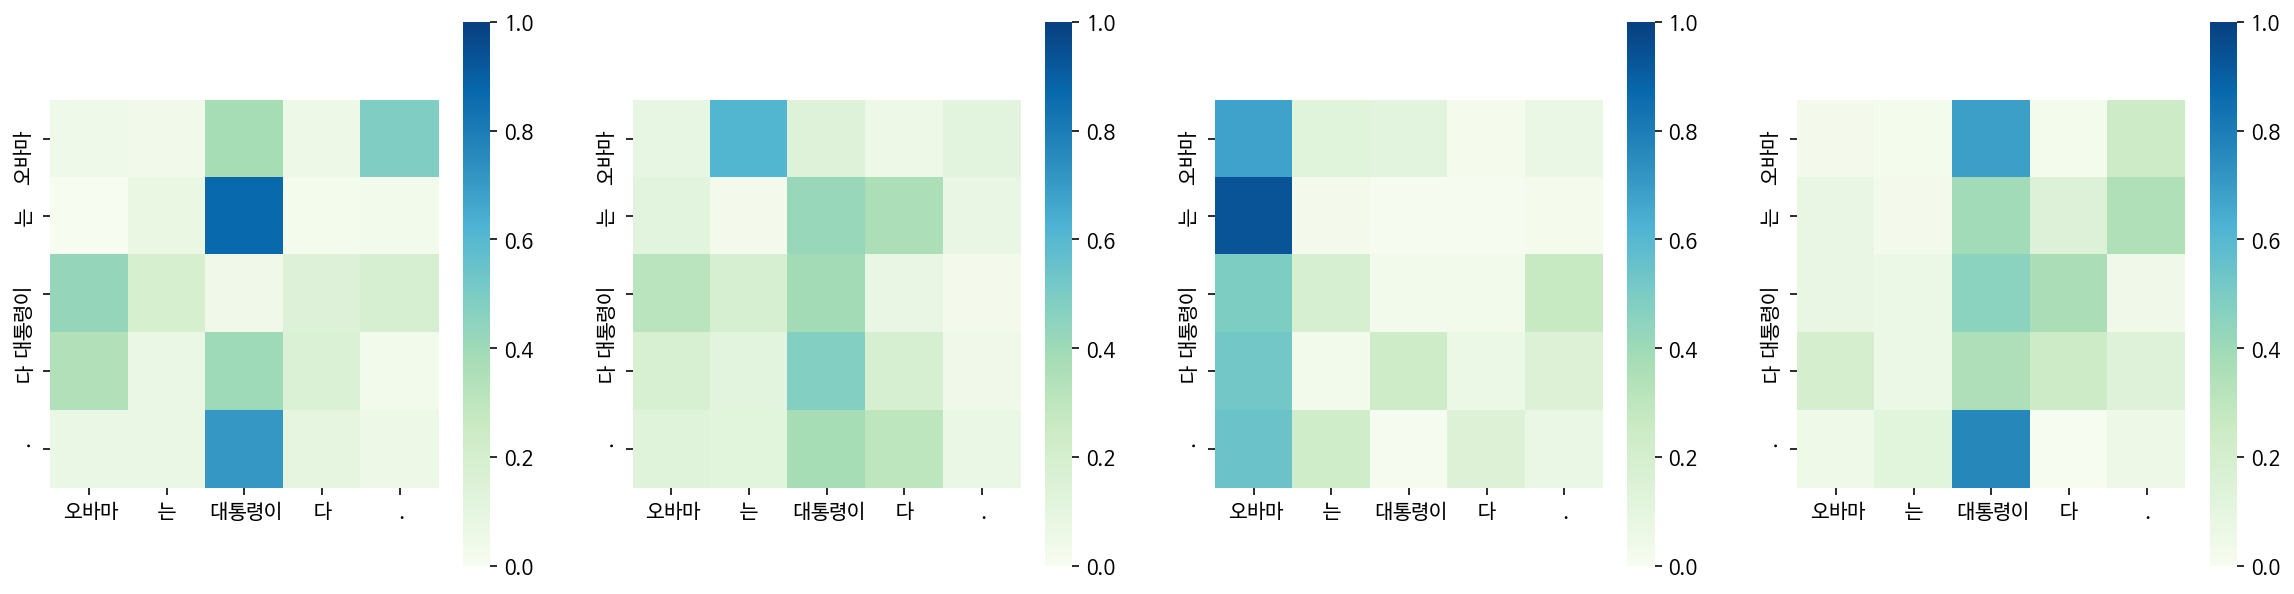

Encoder Layer 2


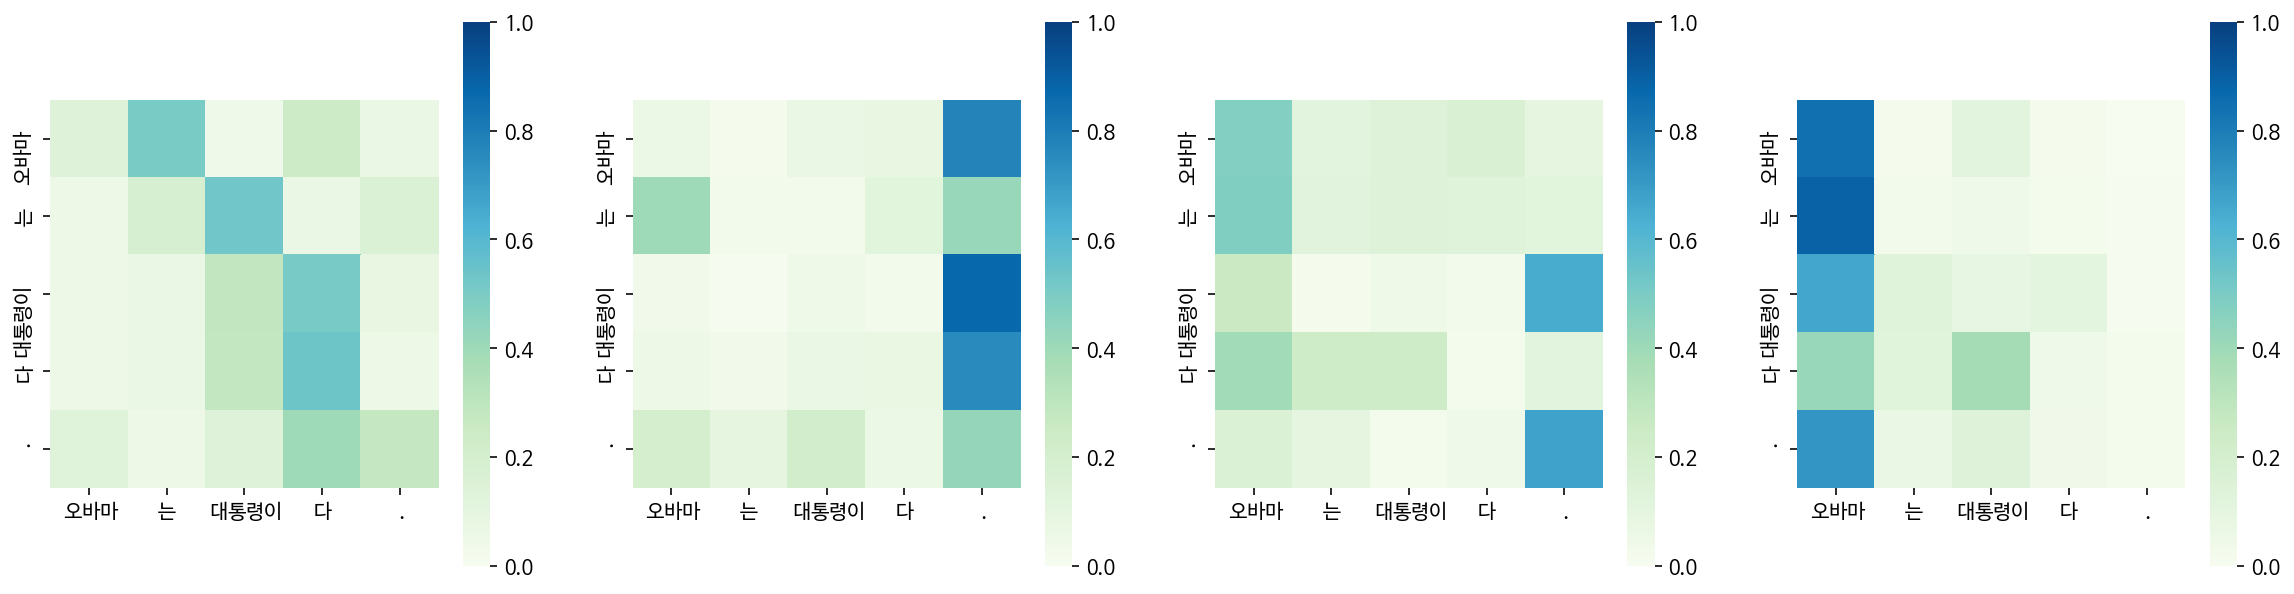

Decoder Self Layer 1


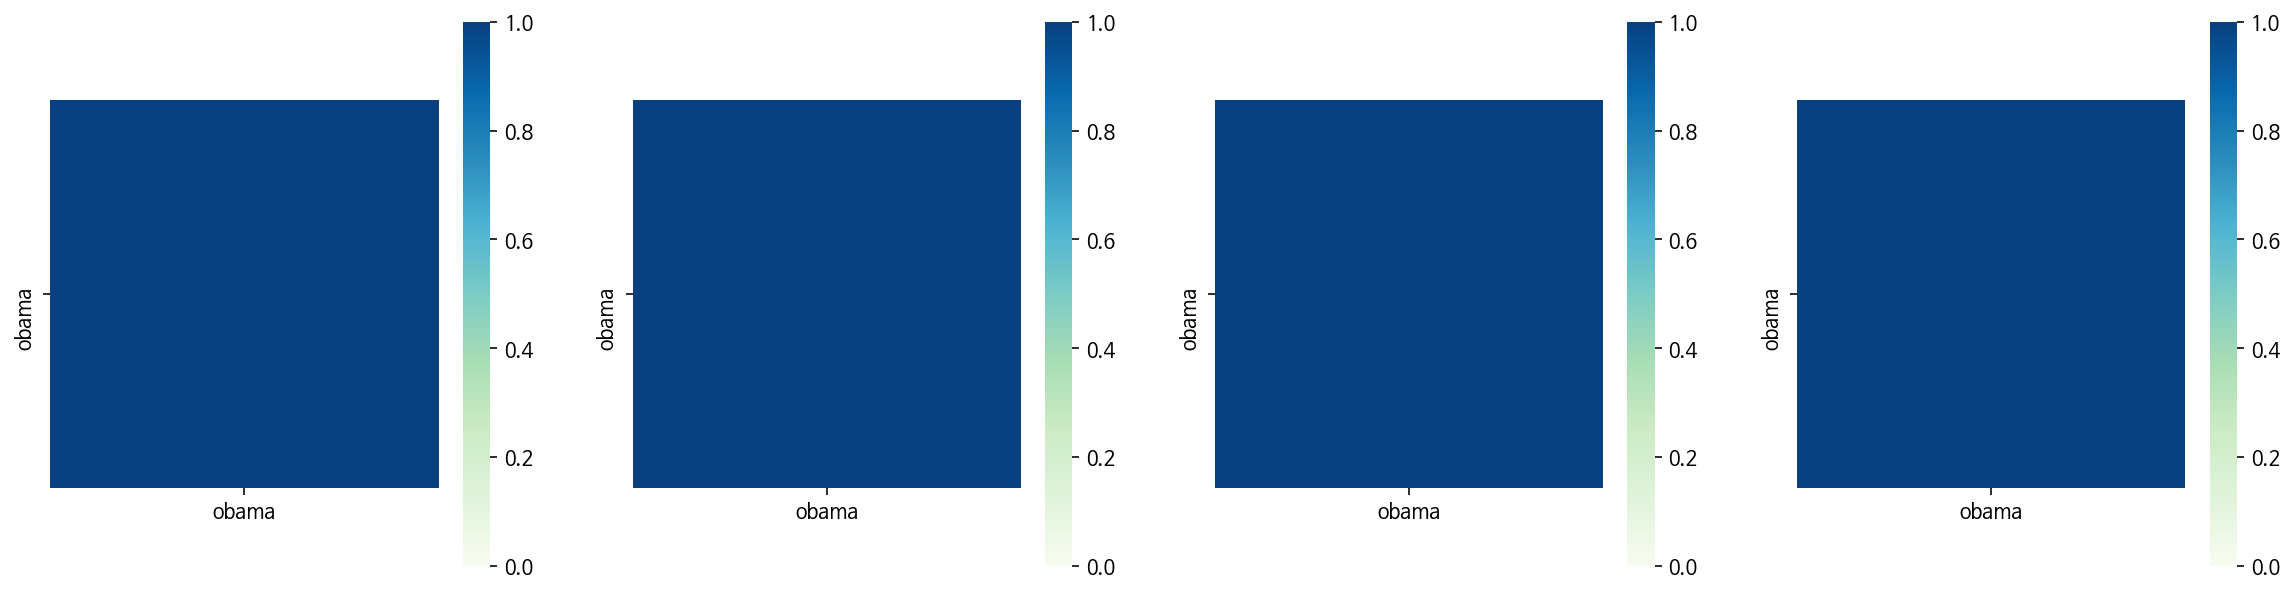

Decoder Src Layer 1


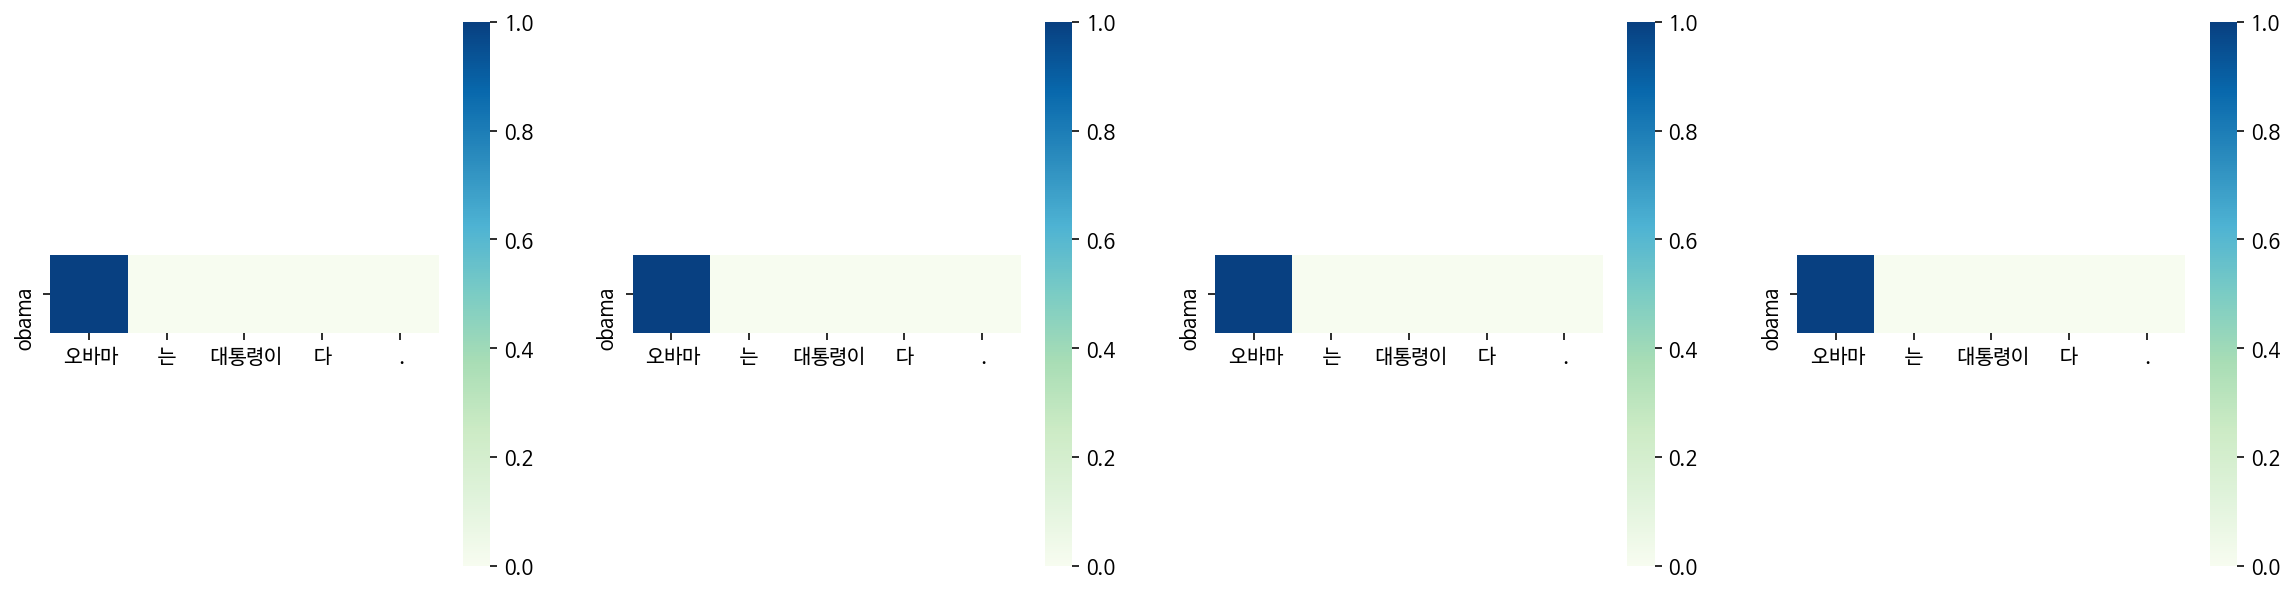

Decoder Self Layer 2


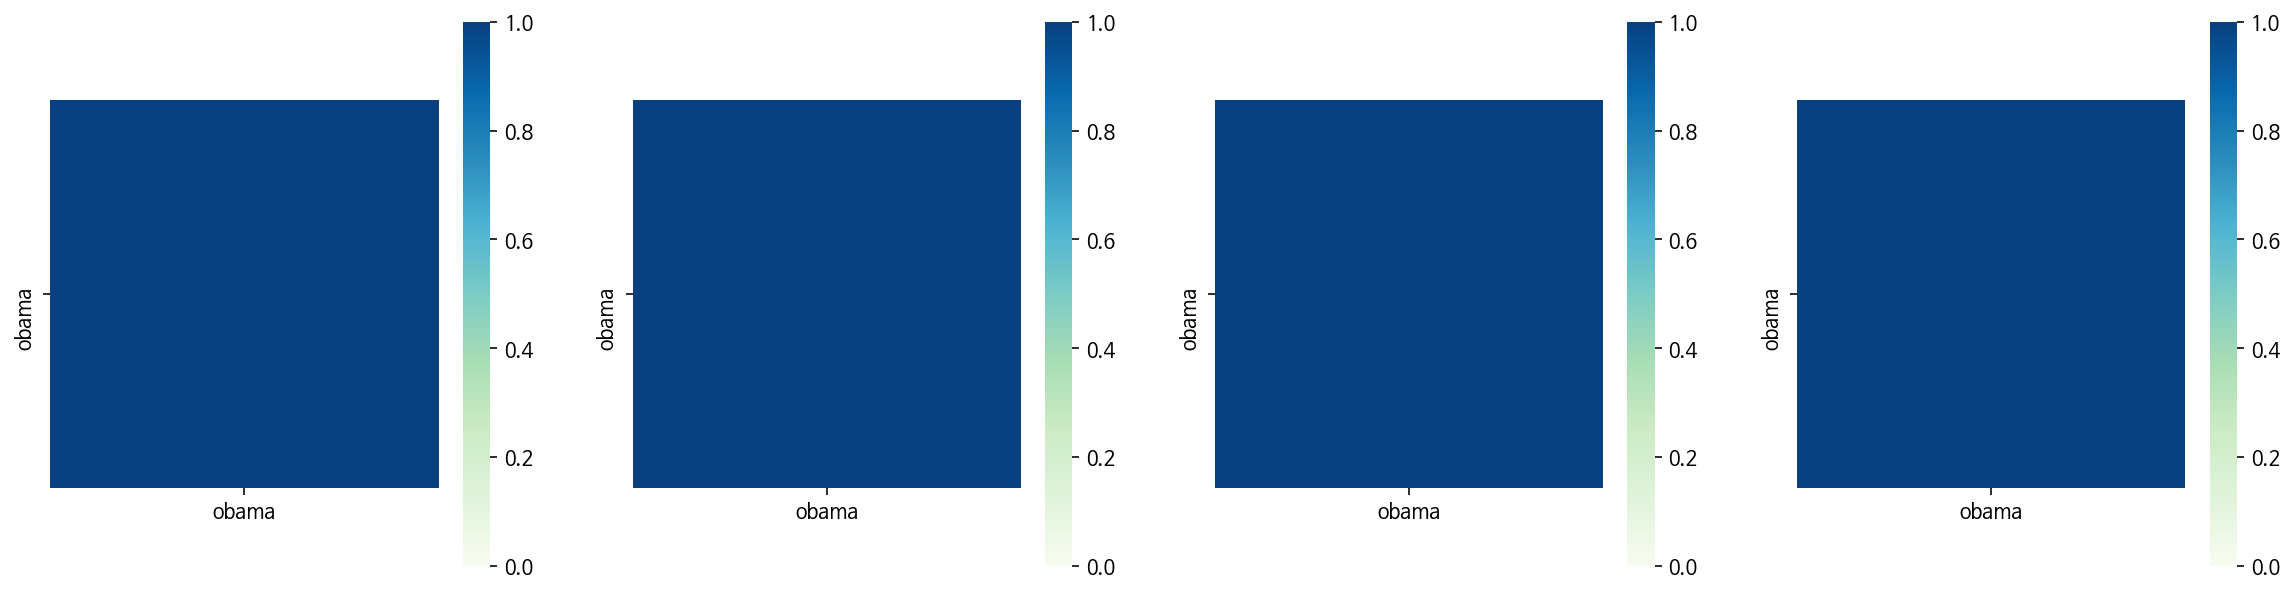

Decoder Src Layer 2


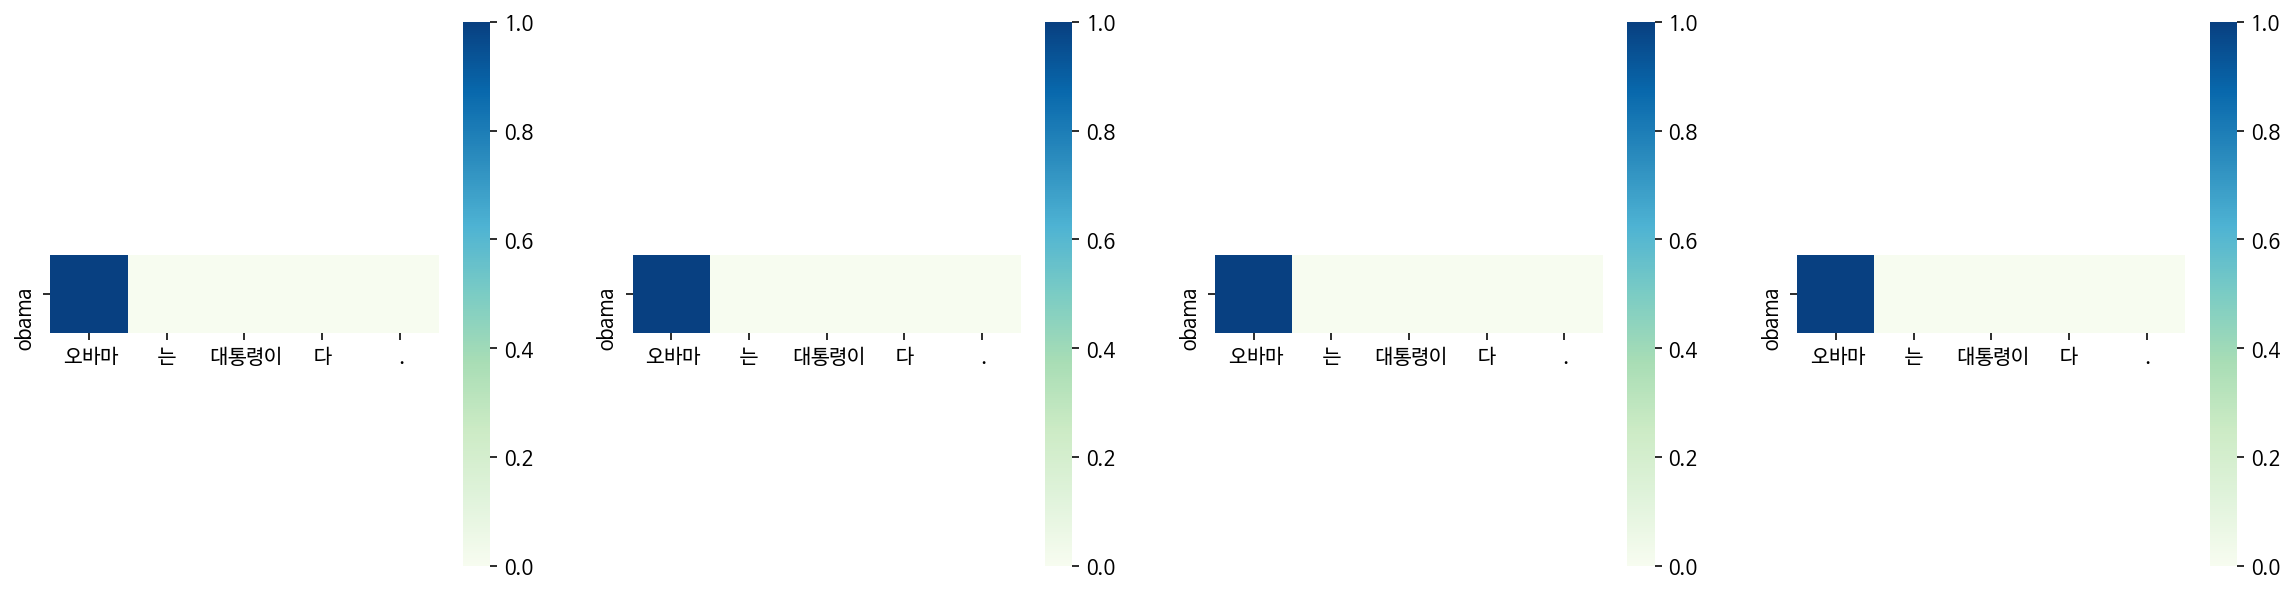

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : 
🇰🇷 : 커피는 필요 없다.
🇺🇸 : any it any it . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : death police seven sevens sevens survivor survivor survivor survivor survivor survivor survivor survivor survivor survivor survivor survivor survivor survivor survivor survivor . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 11]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama isinging . .inginginginginginginginginginginginginginginginginginginginginginginginginginginginging . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : 
🇰🇷 : 커피는 필요 없다.
🇺🇸 : must it
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : deaths . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 12]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : president is president president obama obama . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : 
🇰🇷 : 커피는 필요 없다.
🇺🇸 : co co
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : deaths . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 13]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : 
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : 
🇰🇷 : 커피는 필요 없다.
🇺🇸 : 
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : death  s monda  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 14]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : 
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : 
🇰🇷 : 커피는 필요 없다.
🇺🇸 : 
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : police seven  s wased . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 15]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : 
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : 
🇰🇷 : 커피는 필요 없다.
🇺🇸 : co vehicless time time time . . . .ssssssssssssssssssssssssssssssssssssss .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : police seven victimmentededmentssss . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 16]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : 
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : 
🇰🇷 : 커피는 필요 없다.
🇺🇸 : co vehicle no perform noededededssssssssssssssssssssssssssssssssssssssss
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : death police total police team the death hit hit hit hit hit hit hit hit . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 17]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : 
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : 
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : people seven    . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 18]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : 
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : 
🇰🇷 : 커피는 필요 없다.
🇺🇸 : 
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : death


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 19]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : president obama s point point weather weather president . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : 
🇰🇷 : 커피는 필요 없다.
🇺🇸 : cup cup
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : death      sunday sunday sunday sunday sunday sunday sunday sunday sunday sunday wed wed . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


  0%|          | 0/266 [00:00<?, ?it/s]

[EPOCH = 20]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : president
Encoder Layer 1


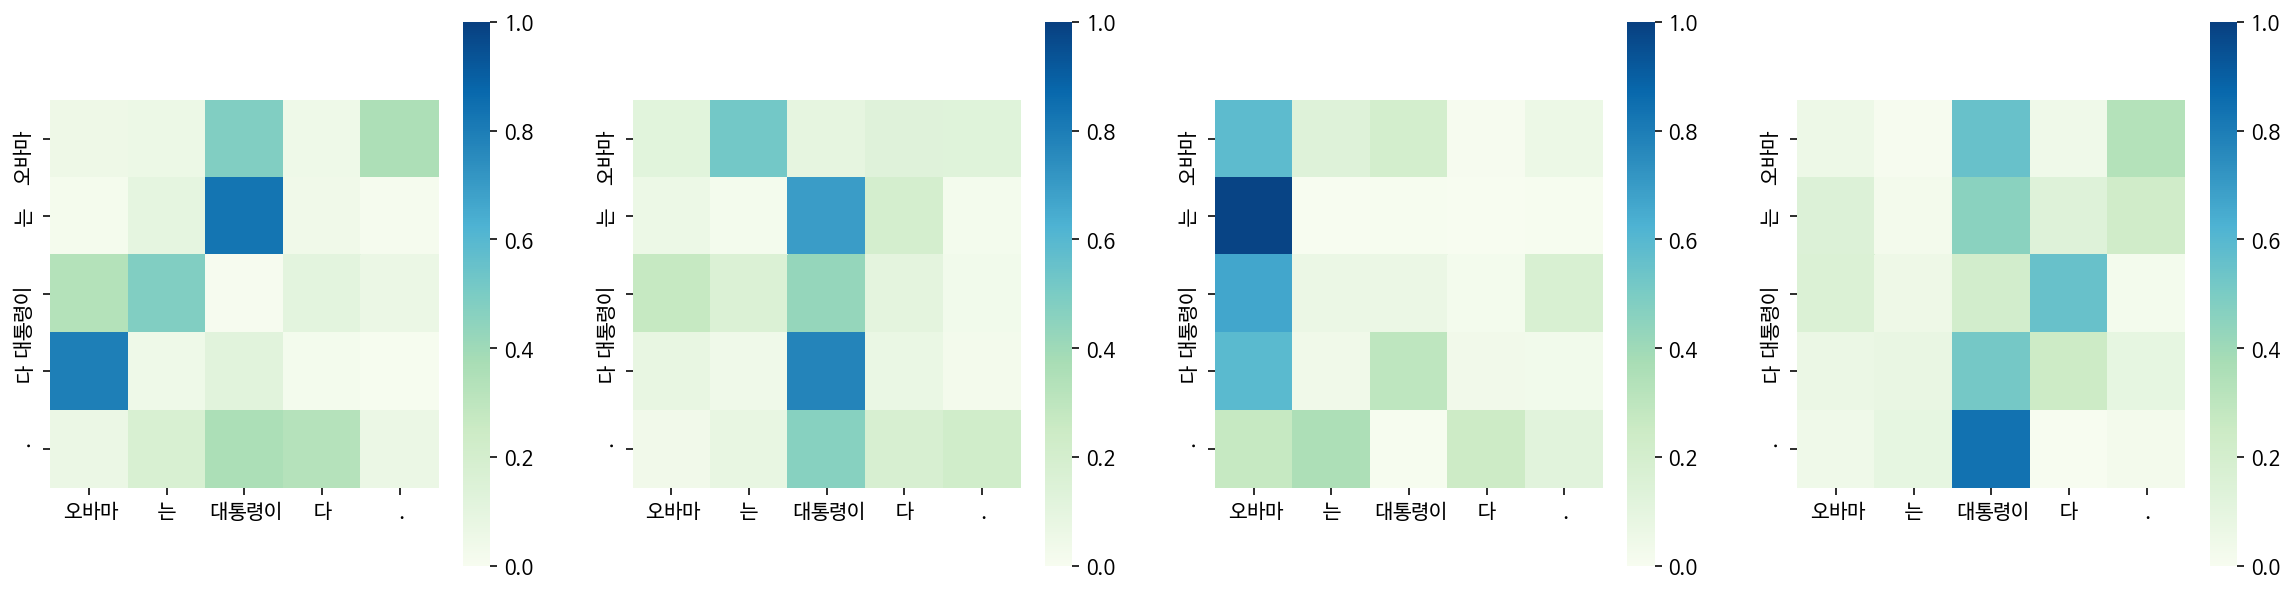

Encoder Layer 2


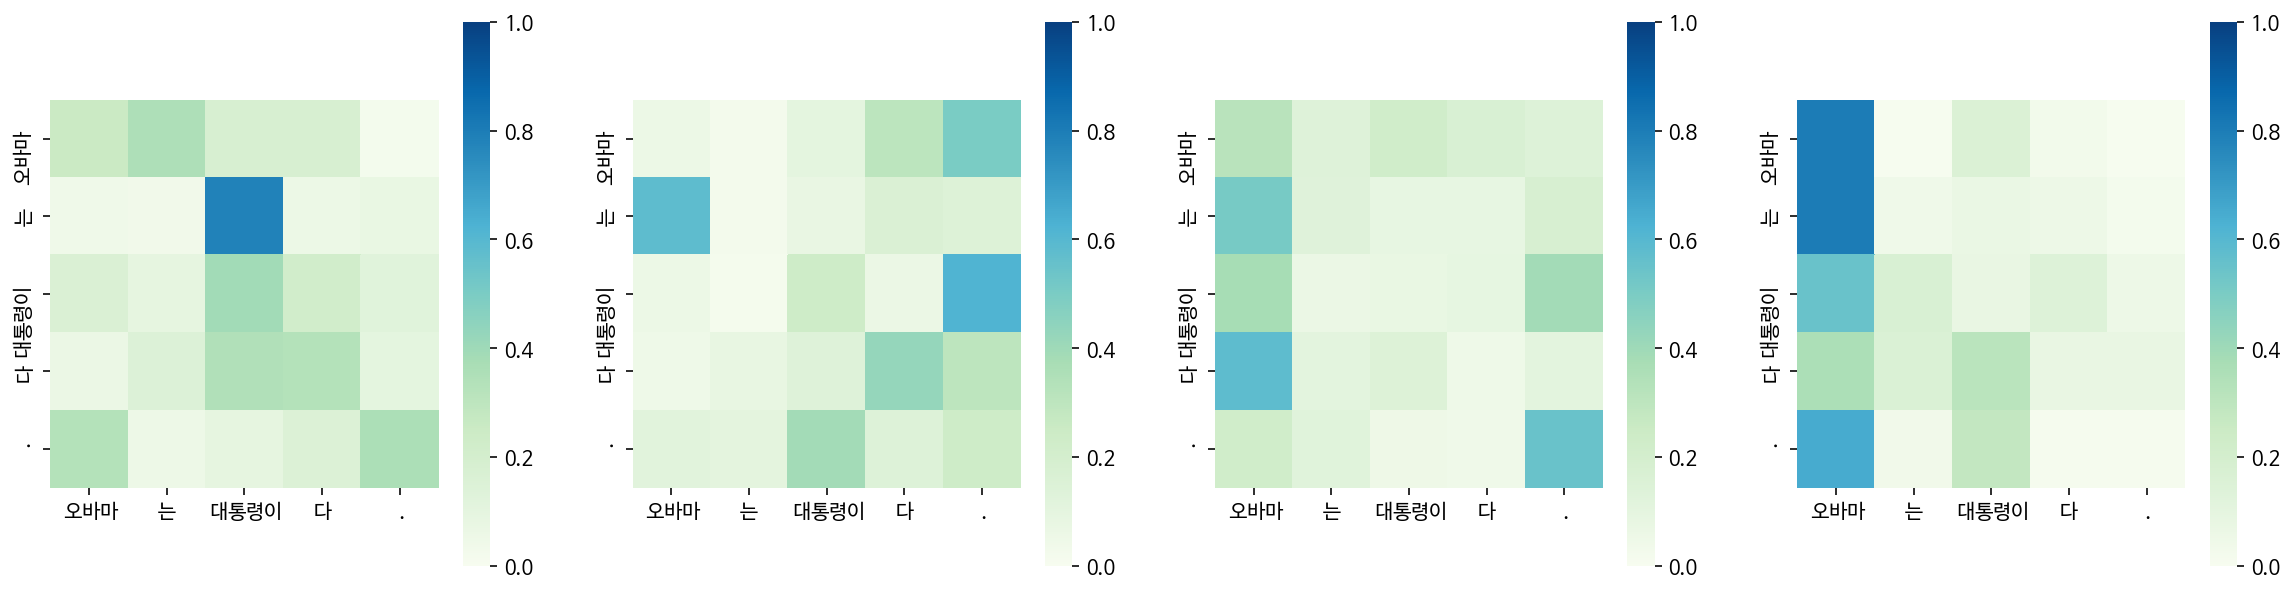

Decoder Self Layer 1


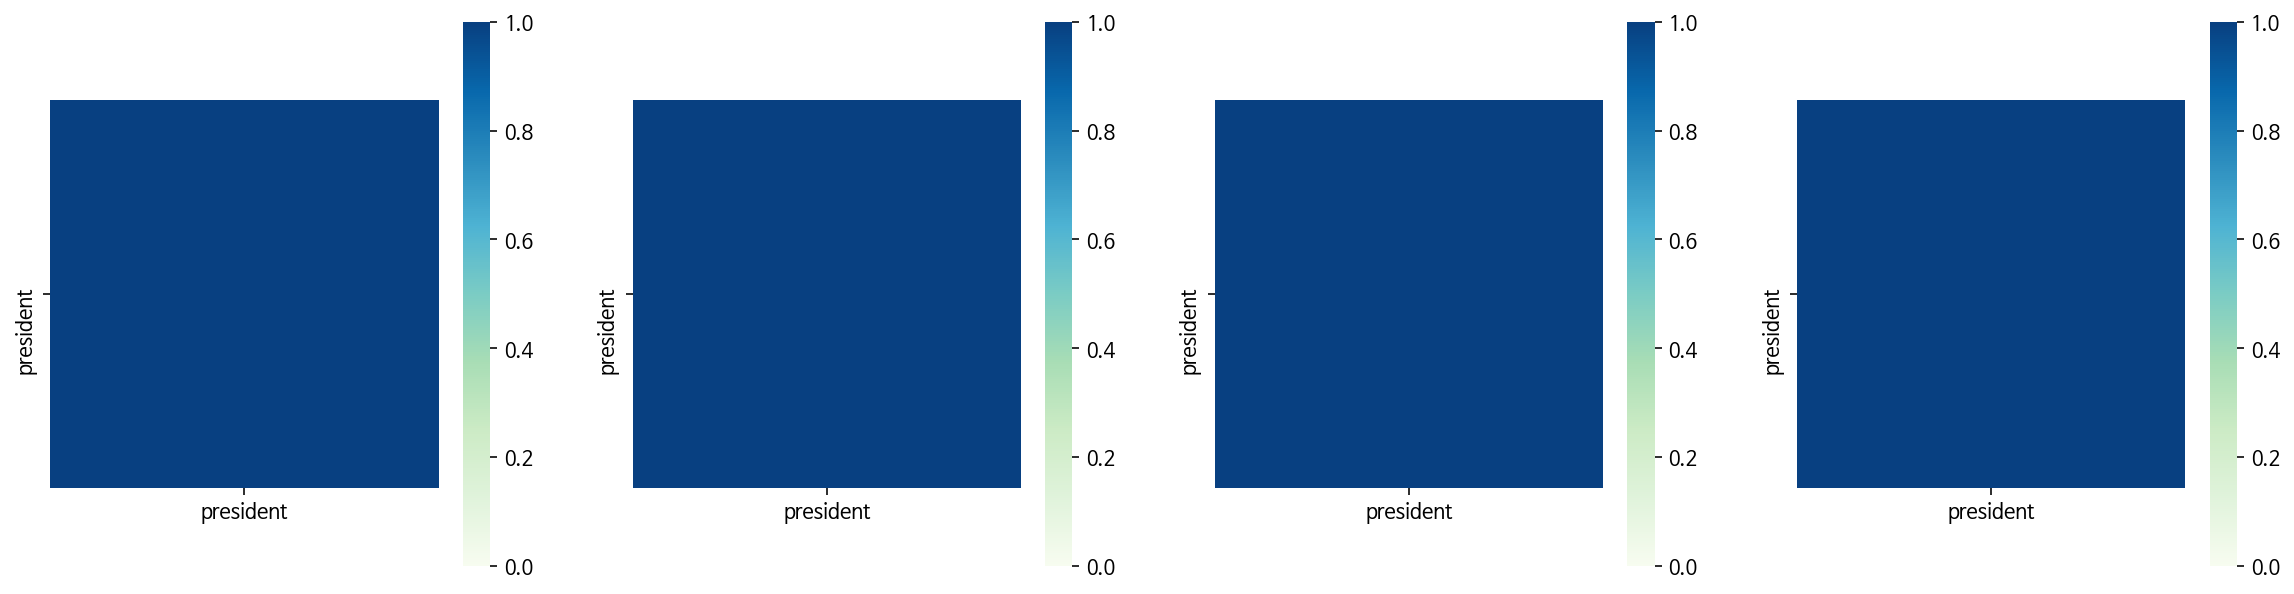

Decoder Src Layer 1


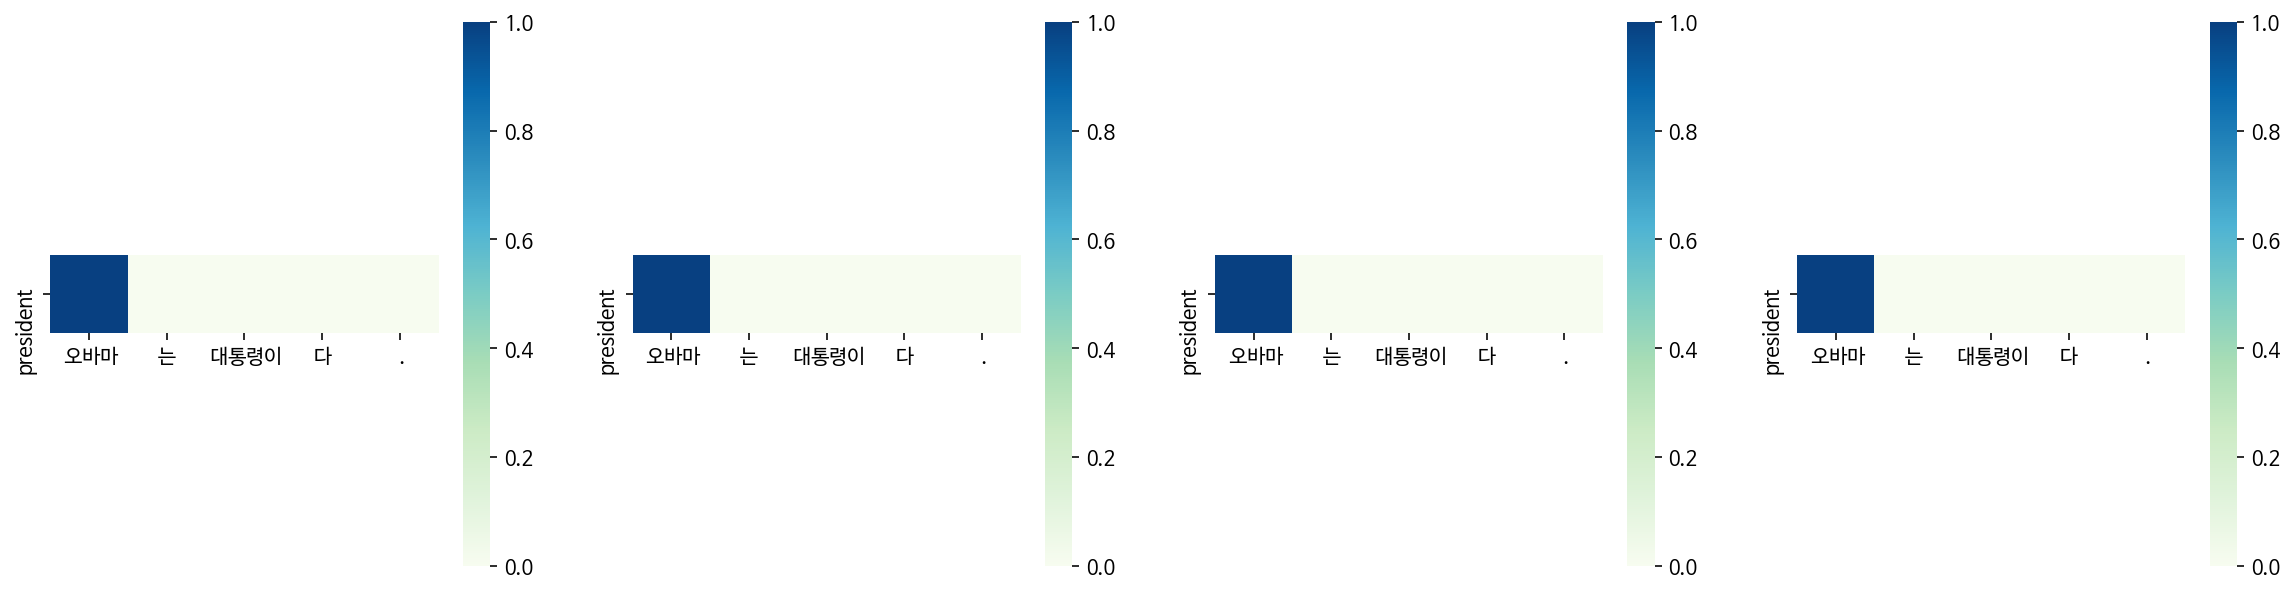

Decoder Self Layer 2


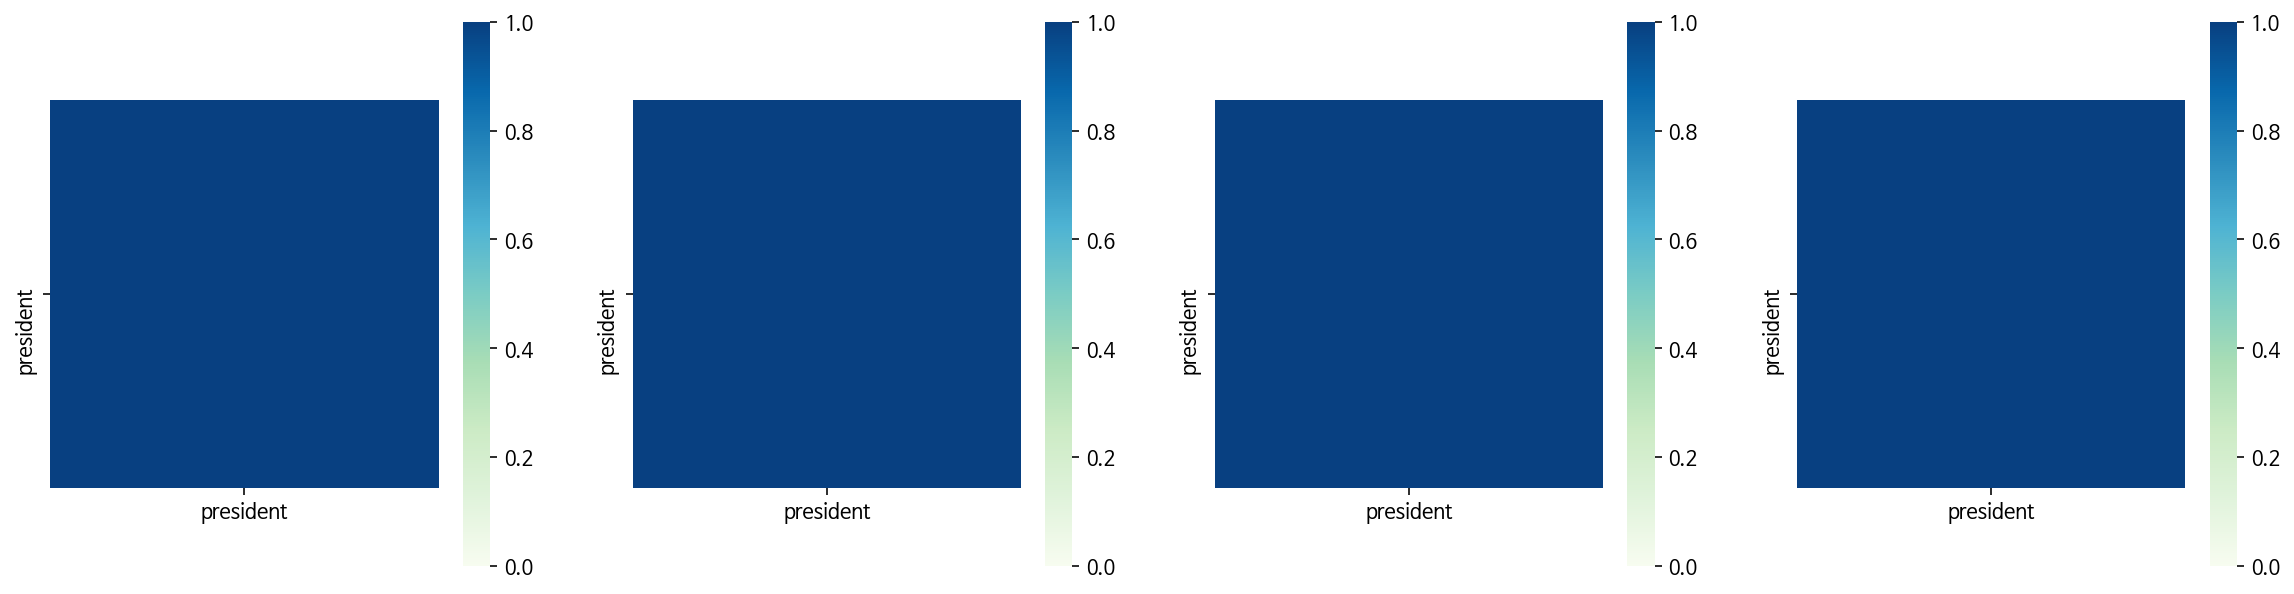

Decoder Src Layer 2


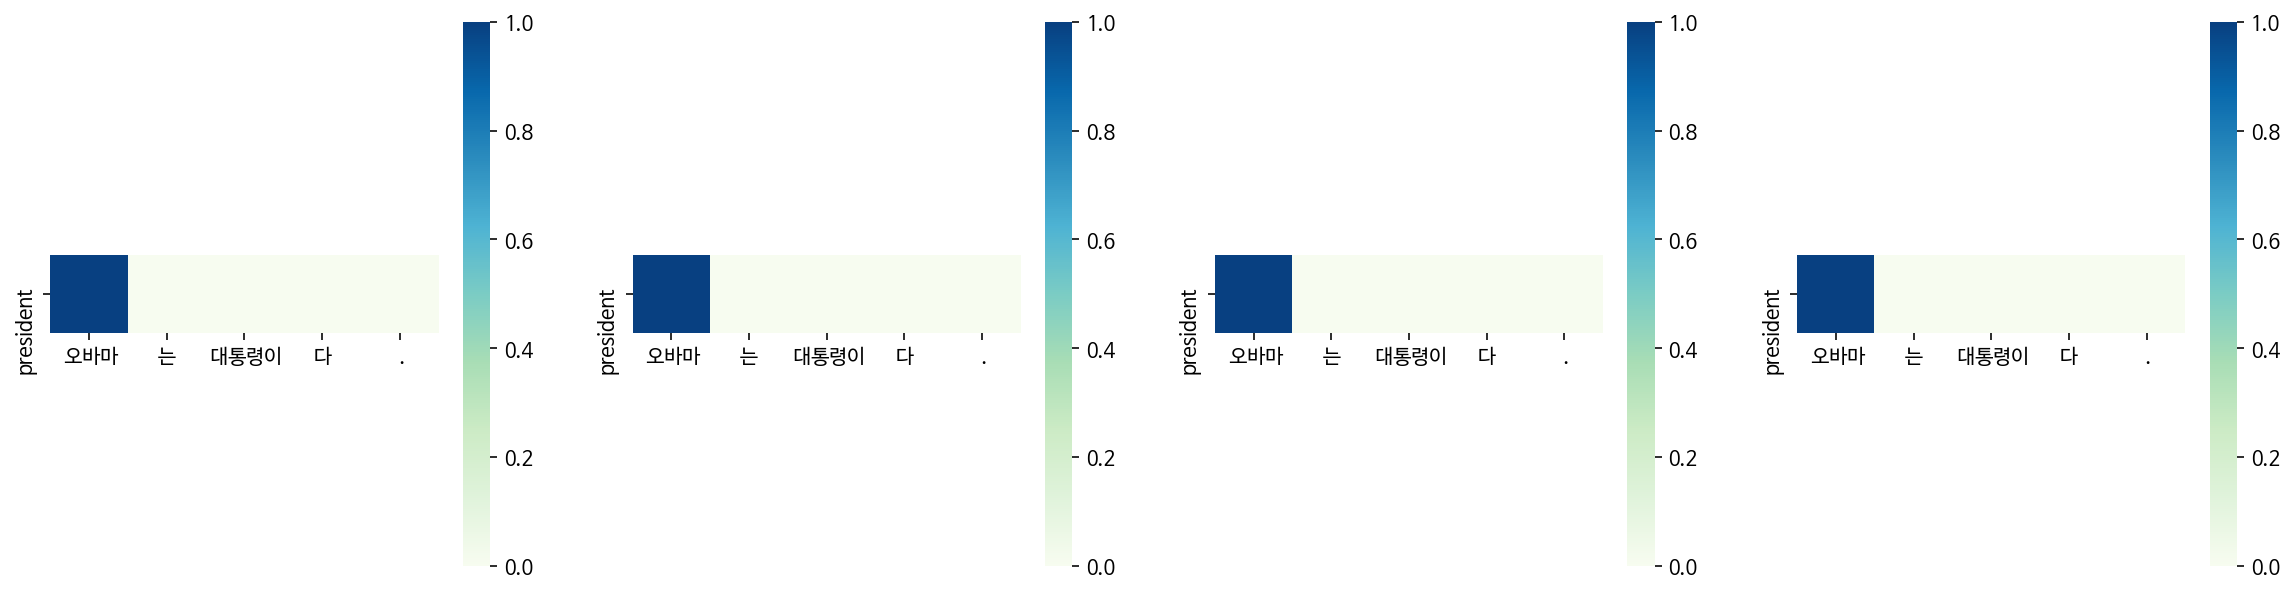

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : 
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee co
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : death      hit hit hit hit hit hit hit hit hit hit hit hit


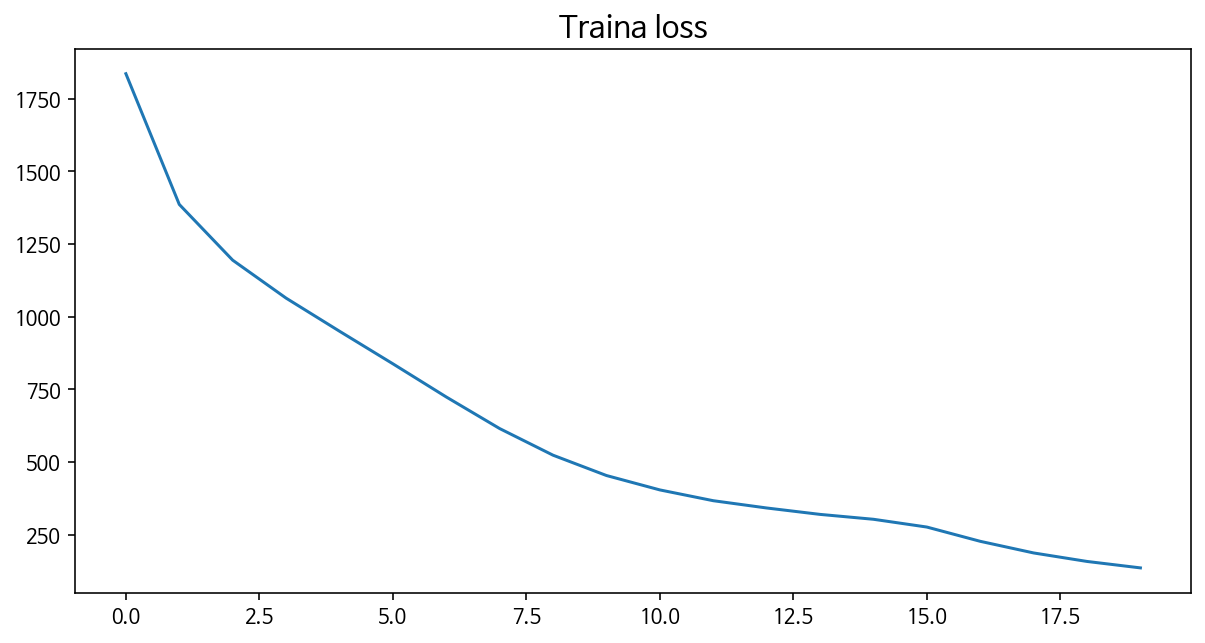

In [36]:
losses = train(transformer, optimizer, enc_train, dec_train, 
               ko_tokenizer, en_tokenizer, examples, 20, 256)
show_train_loss(losses)

In [43]:
def print_result(model, src_tokenizer, tgt_tokenizer, sentences,
                n_layers=2, d_model=512, n_heads=8, d_ff=2048, dropout=0.1):
    
    print("Translations")
    for i, sentence in enumerate(sentences):
        pieces, result, enc_attns, dec_attns, dec_enc_attns = \
            evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
        print(f"> {i+1}. {result}")
    
    print()
    print('Hyperparameters')
    print(f'> n_layers: {n_layers}')
    print(f'> d_model: {d_model}')
    print(f'> n_heads: {n_heads}')
    print(f'> d_ff: {d_ff}')
    print(f'> dropout: {dropout}')

In [39]:
print_result(transformer, ko_tokenizer, en_tokenizer, examples,
             n_layers=2, d_model=512, n_heads=8, d_ff=2048, dropout=0.3)

Translations
> 1. president
> 2. 
> 3. coffee co
> 4. death      hit hit hit hit hit hit hit hit hit hit hit hit

Hyperparameters
> n_layers: 4
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3


In [35]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(
            _input, output)
        
        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, 
                                                                 output,
                                                                 enc_padding_mask,
                                                                 combined_mask,
                                                                 dec_padding_mask)
        
        predictions = predictions[:, -1:, :]
        predicted_id = tf.argmax(predictions, axis=-1).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [36]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [37]:
def generate_masks(inp, tar):
  # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [38]:
hyperparameters_3 = {
    'n_layers' : 2,
    'd_model' : 512,
    'n_heads' : 8,
    'd_ff' : 2048,
    'dropout' : 0.3
}

transformer_3 = Transformer(n_layers=hyperparameters_3['n_layers'], 
                          d_model=hyperparameters_3['d_model'], 
                          n_heads=hyperparameters_3['n_heads'], 
                          d_ff=hyperparameters_3['d_ff'], 
                          src_vocab_size=SRC_VOCAB_SIZE, 
                          tgt_vocab_size=TGT_VOCAB_SIZE, 
                          pos_len=50, 
                          dropout=hyperparameters_3['dropout'])

In [39]:
learning_rate = LearningRateScheduler(hyperparameters_3['d_model'])
optimizer_3 = tf.keras.optimizers.Adam (learning_rate,
                                       beta_1=0.9,
                                       beta_2=0.98, 
                                       epsilon=1e-9)

  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 1]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : theys are in they .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : they of they of they .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : they , they .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : they of they .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 2]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama s not been obama s .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : they are not beenough .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : we are not to going .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : they were killed in they were killed .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 3]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama is the first times .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : they are then t been in the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : we re not beenough .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the death toll in the death toll .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 4]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama is ahead of .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : they have been around the city of the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : we re going to get yourself .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the death tolls , and the death toll in the death toll .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 5]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : they are then the city swine flu .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee coffee coffee coffee coffee coffee coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the death toll was killed .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 6]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama is to make obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city s largest city is around .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee is not true .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the death toll was killed .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 7]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama is expected to be around obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is around the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : kinne is , for coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the death toll was killed .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 8]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama is obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city s city of the city s city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : there is no longer need for its easy to make it .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the fatalities were killed in the fatalities .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 9]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama , the president , obama s president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : they re looking into the city of the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : there is no longer need for its easy to take
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : three people were killed in the northern portland struck .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 10]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama is .
Encoder Layer 1


/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


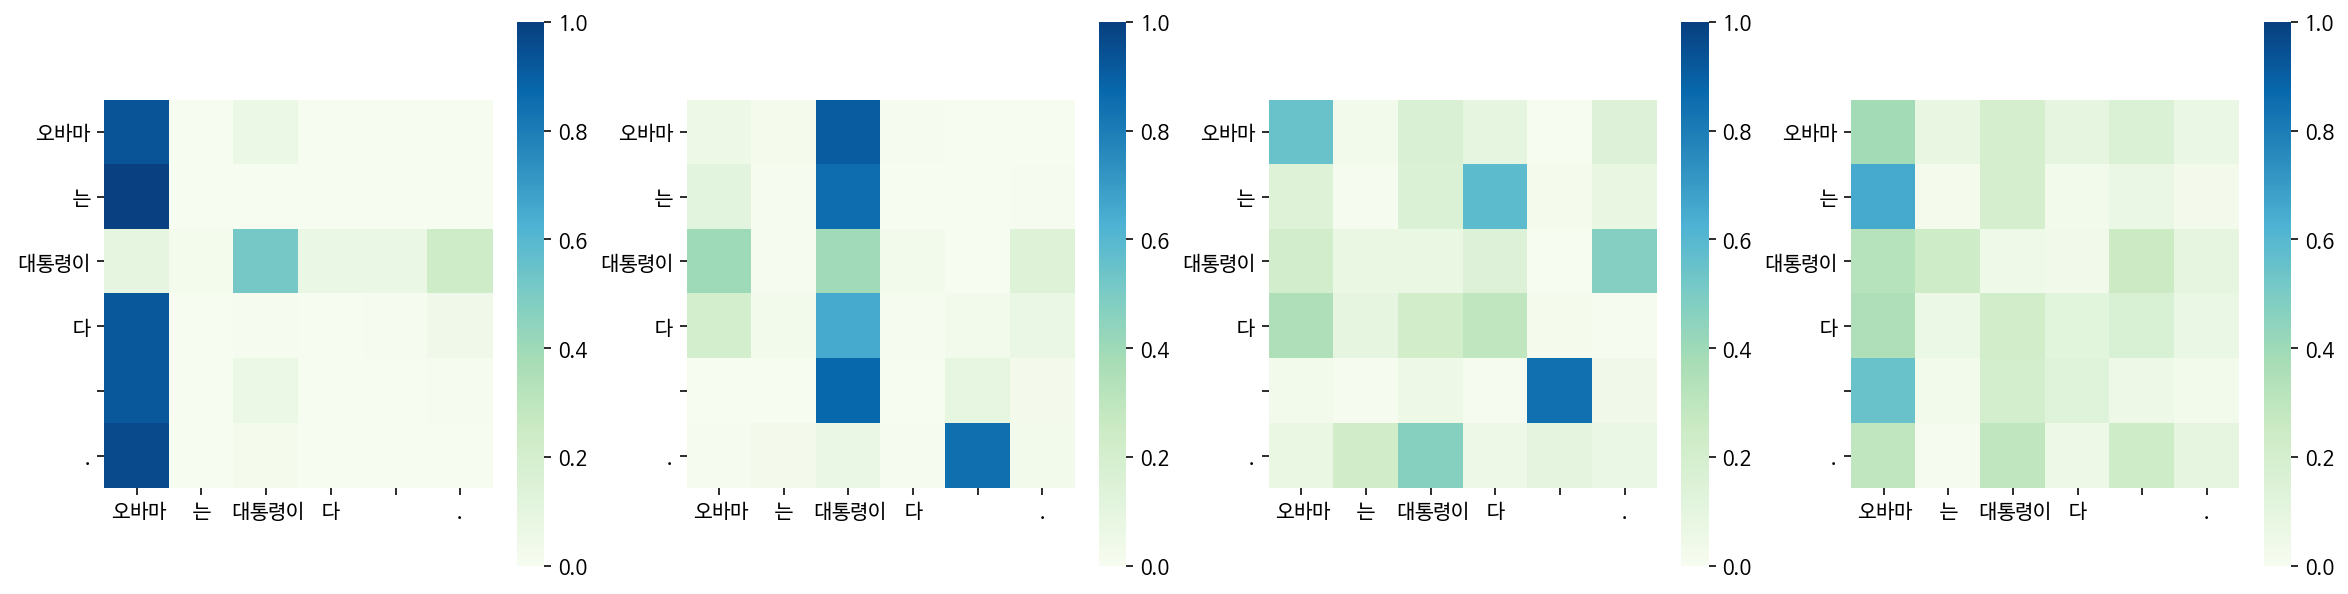

Encoder Layer 2


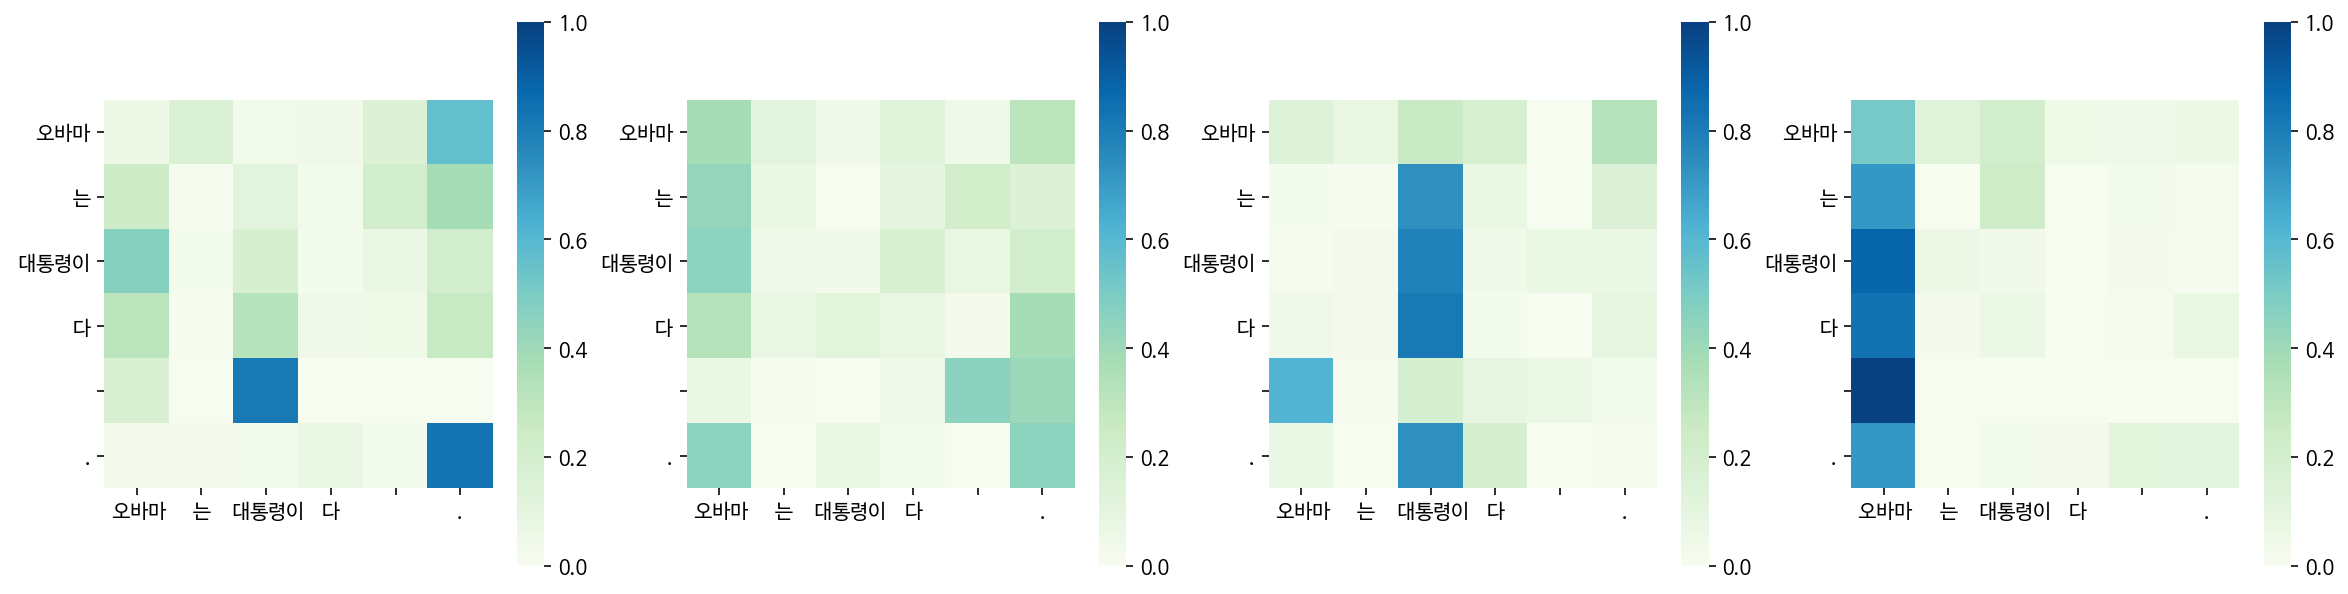

Decoder Self Layer 1


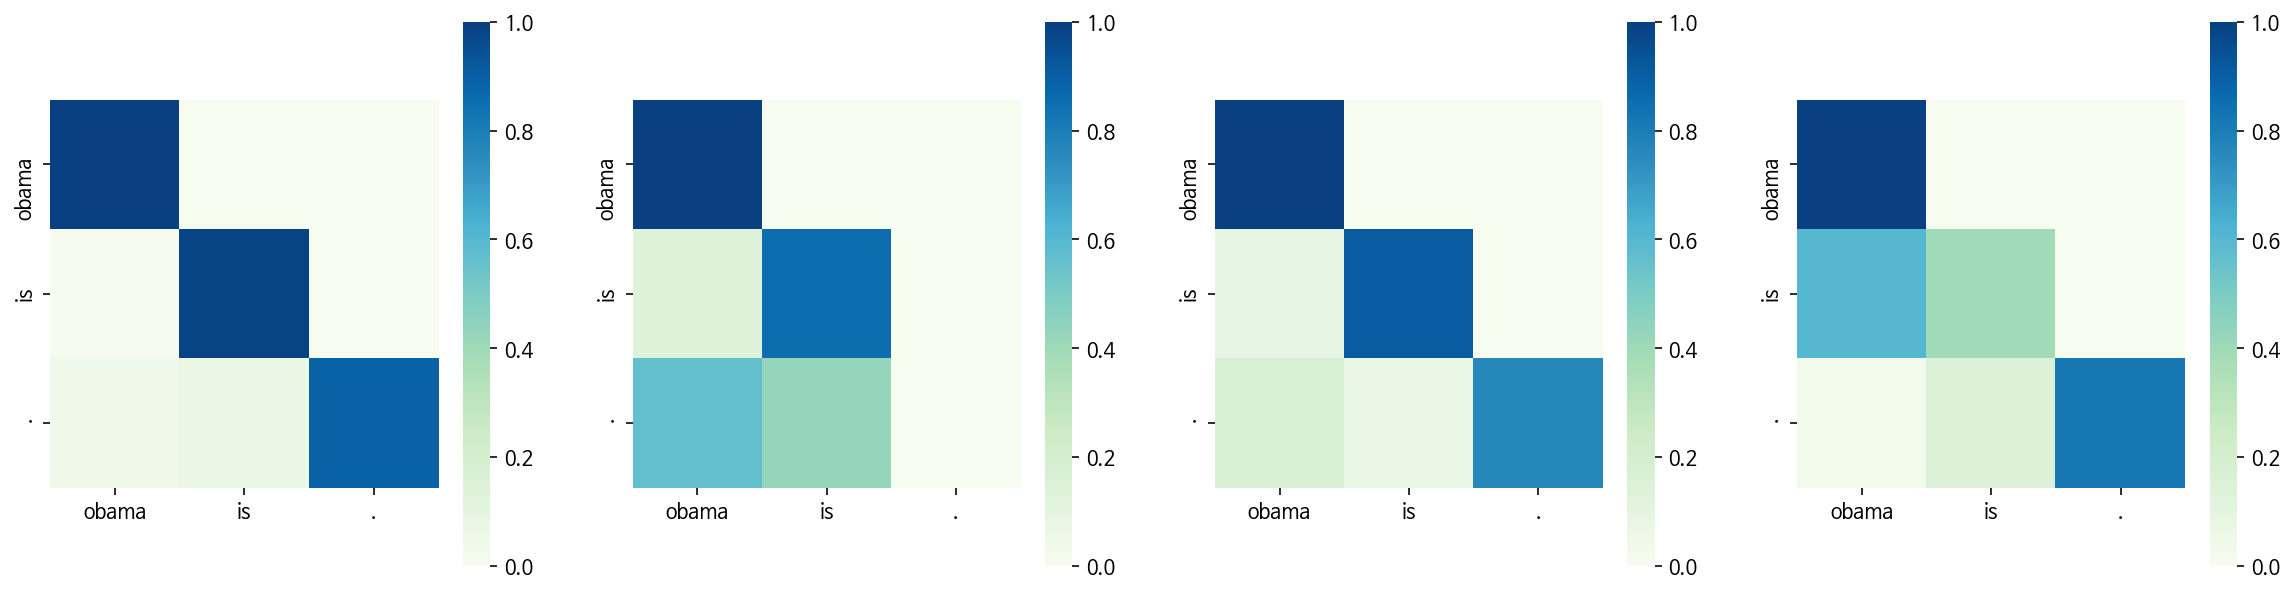

Decoder Src Layer 1


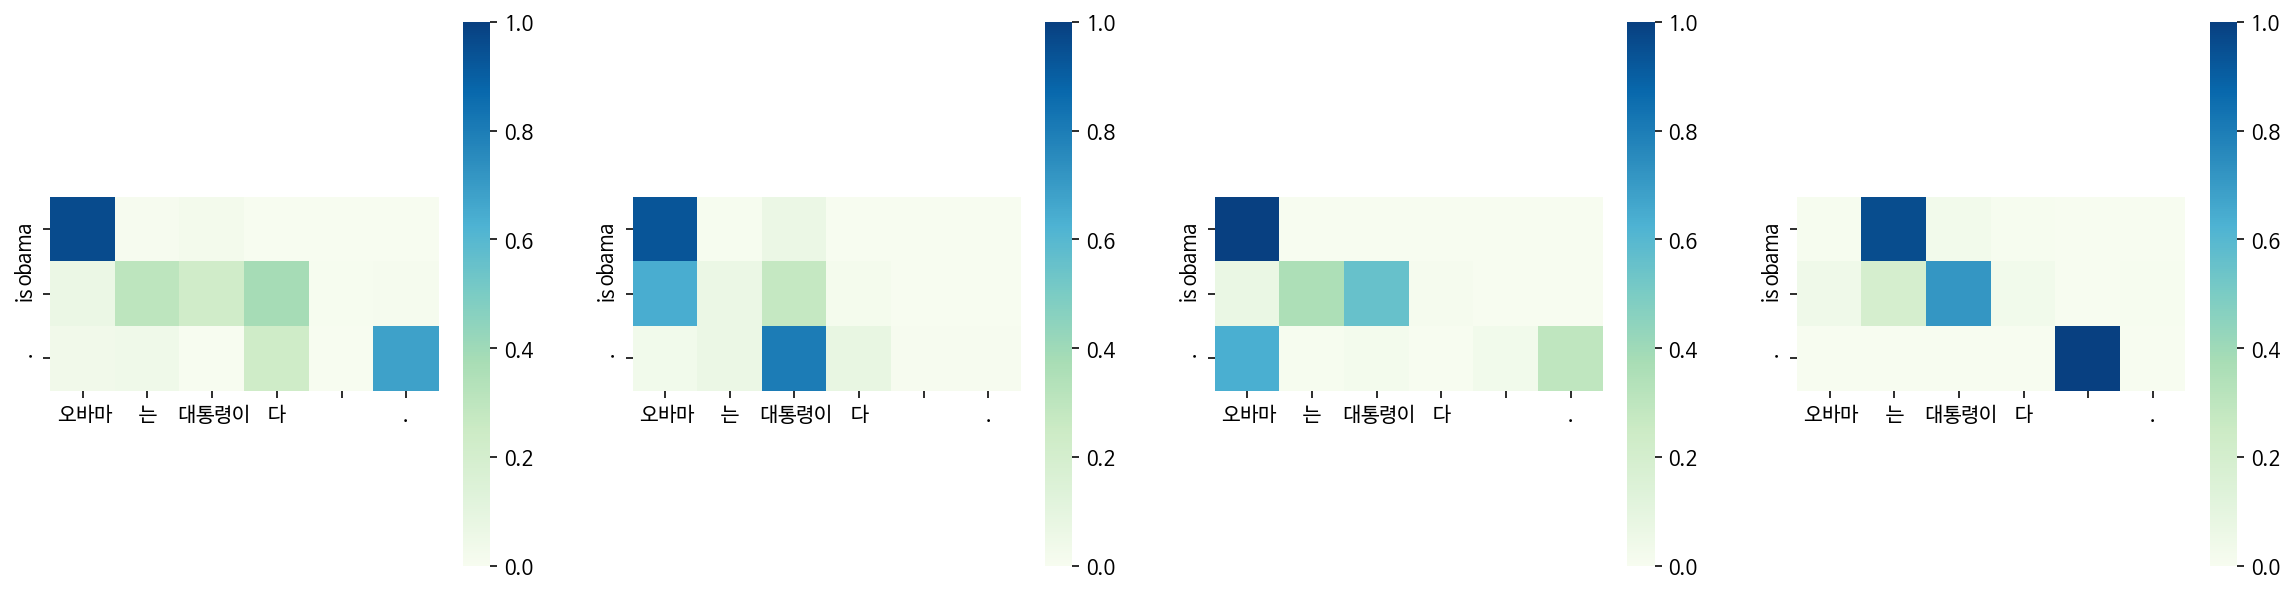

Decoder Self Layer 2


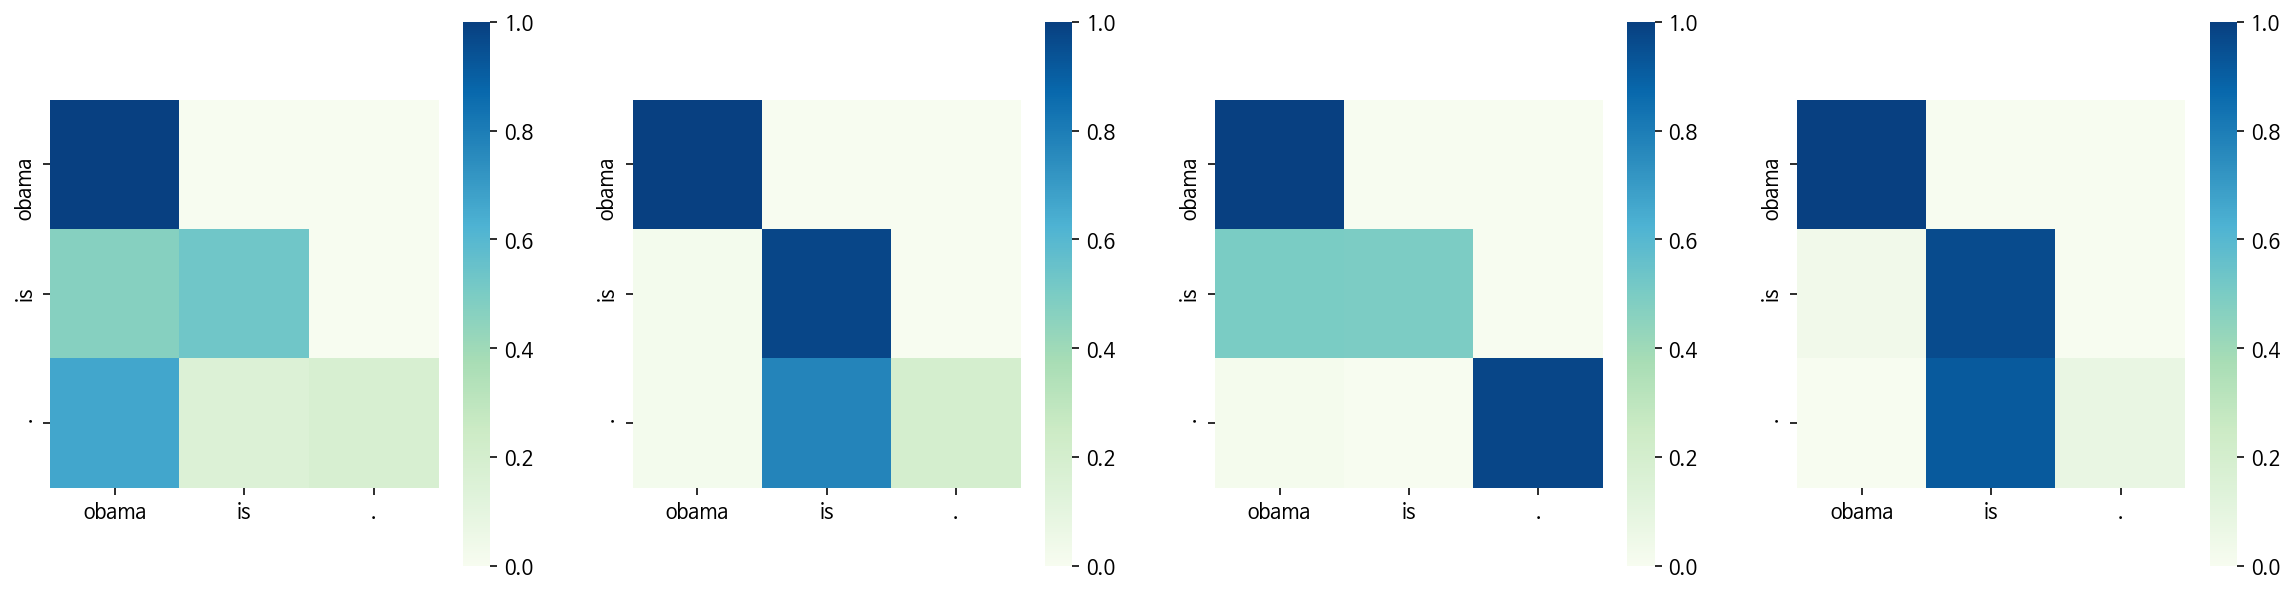

Decoder Src Layer 2


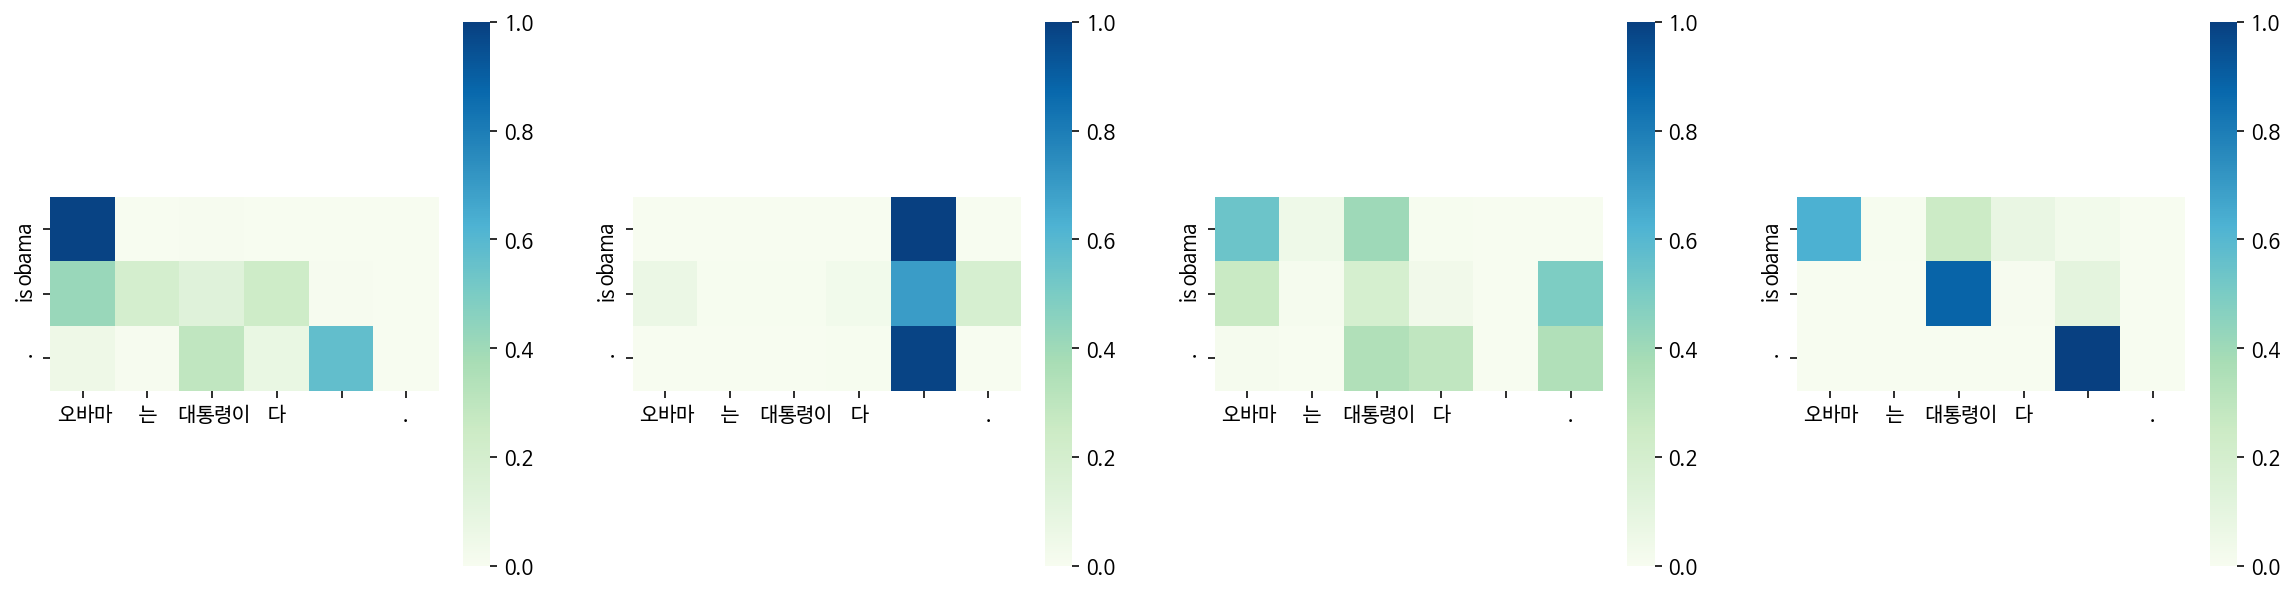

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city of the urban city is in .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : there need to be there .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : four people died from the fatalities sunday , the fatality died .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 11]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama has ad president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the operation is the city of the city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : there s no need for coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the fatality died on august .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 12]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama to tie the president .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : they are the city s biggest in .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : don t need for leaving your job .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : three people died on friday .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 13]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama picked up on obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is a big in baghdad city .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee needed coffee for its need .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the death toll from the six , people , and three .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 14]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : president obama was up .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the surrounding streets cities are the city s .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : there is no chance for coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : five people were dead and five u . s . on the other fatalities .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 15]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama , he retired obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : they watch the city s snow stretched in the city of .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee needs needed coffee or needed .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : six people died on saturday .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 16]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama is , he points .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the mountain is the city seen .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee has no coffee for coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : six people died on sunday from the fatalities .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 17]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : he is obama , he is obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is a tough snow too .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : there need to be so easy or need .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : on jankovic the fourth fatality at the time .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 18]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : obama , the president will be .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city ss are citing an iraqi city s neighboring cities .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee has just needed coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : the dead toll was on the fourth fatality in the race for the dead nine six , police said .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 19]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : he is obama .
🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is around , .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : coffee has no coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : six people died on saturday , seven deaths and nine were at the time .


  0%|          | 0/265 [00:00<?, ?it/s]

[EPOCH = 20]
🇰🇷 : 오바마는 대통령이다.
🇺🇸 : he is obama .
Encoder Layer 1


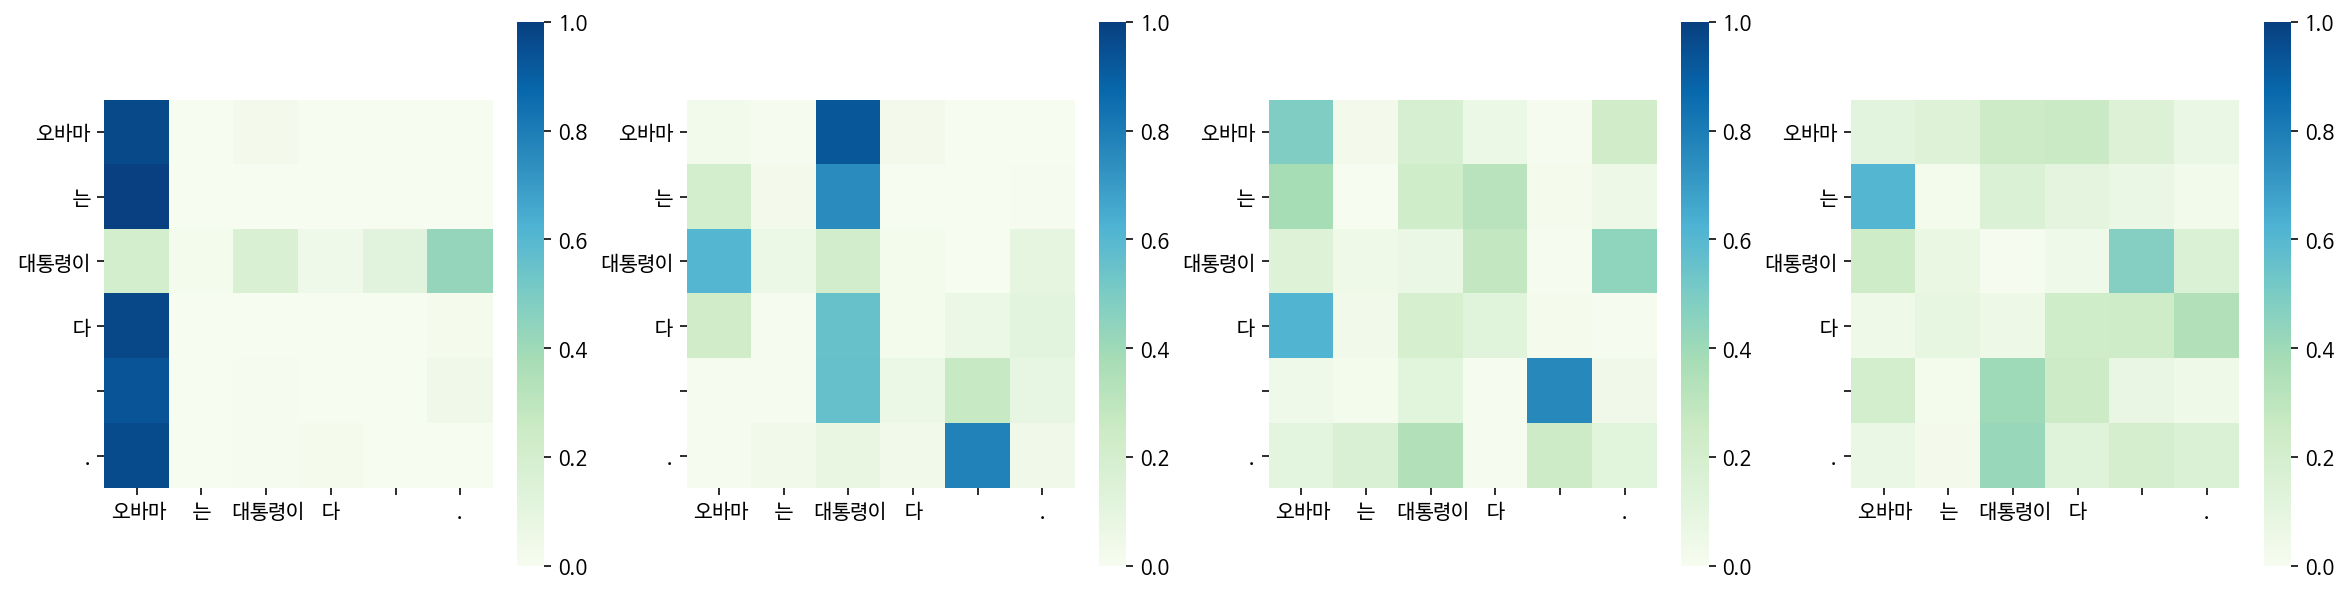

Encoder Layer 2


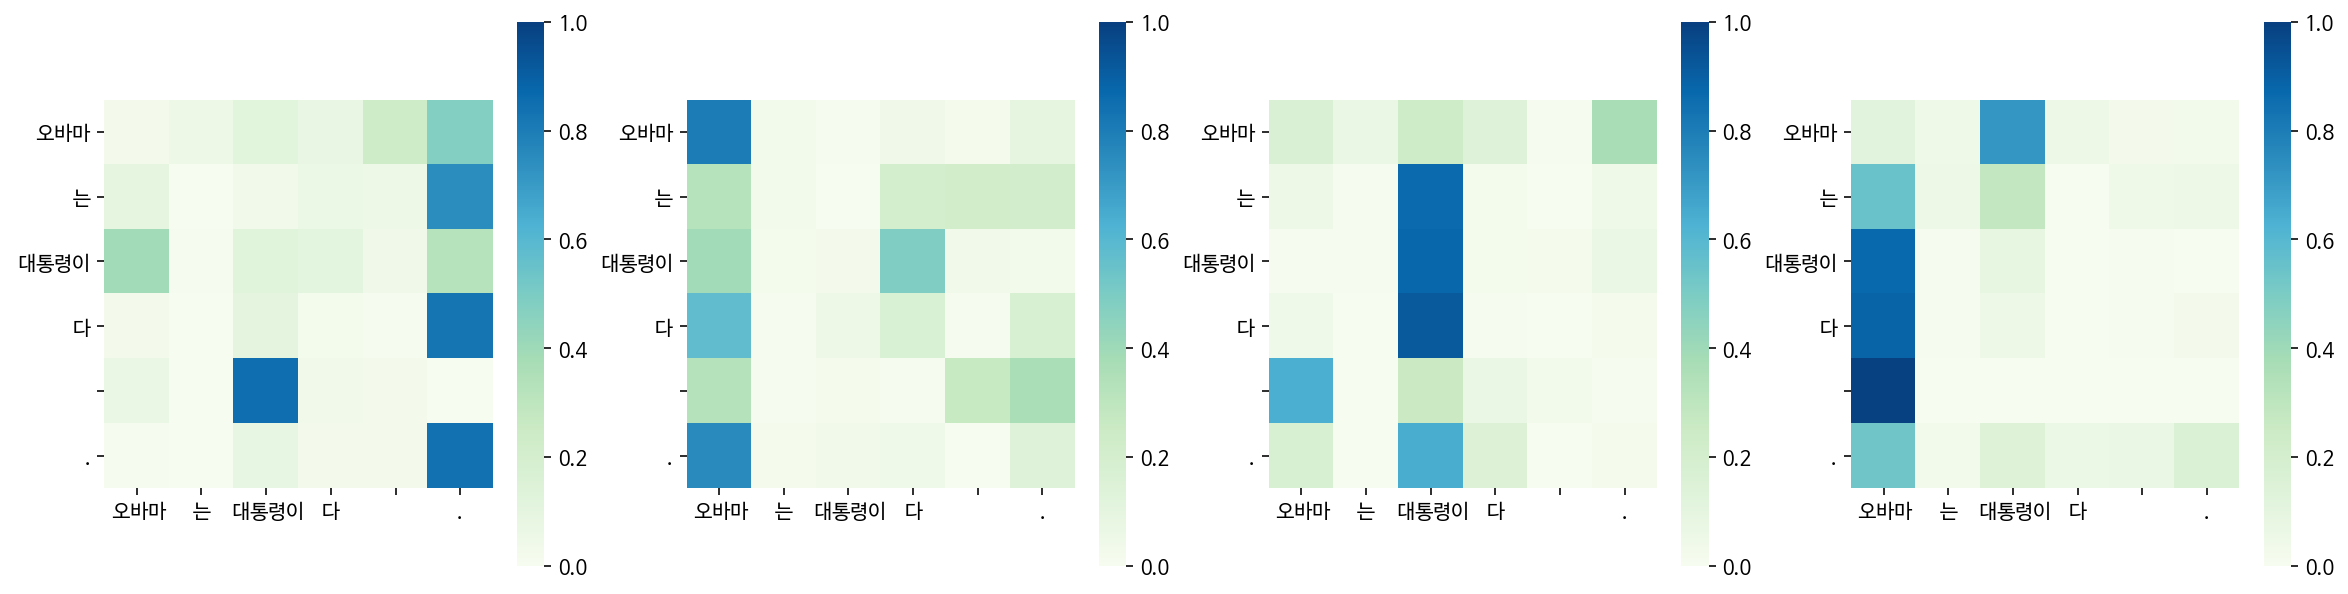

Decoder Self Layer 1


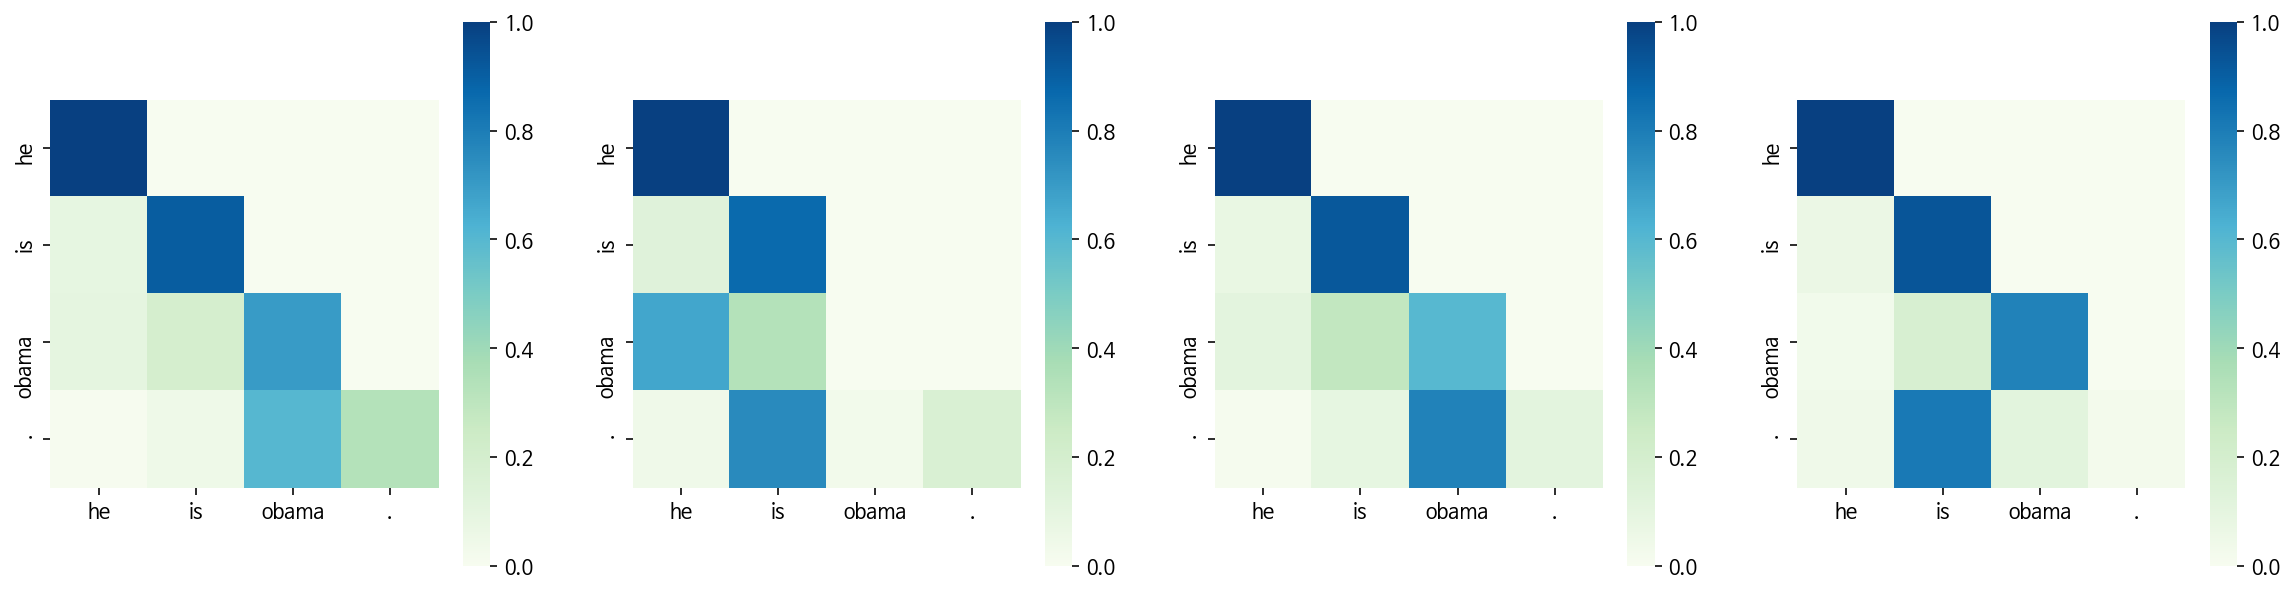

Decoder Src Layer 1


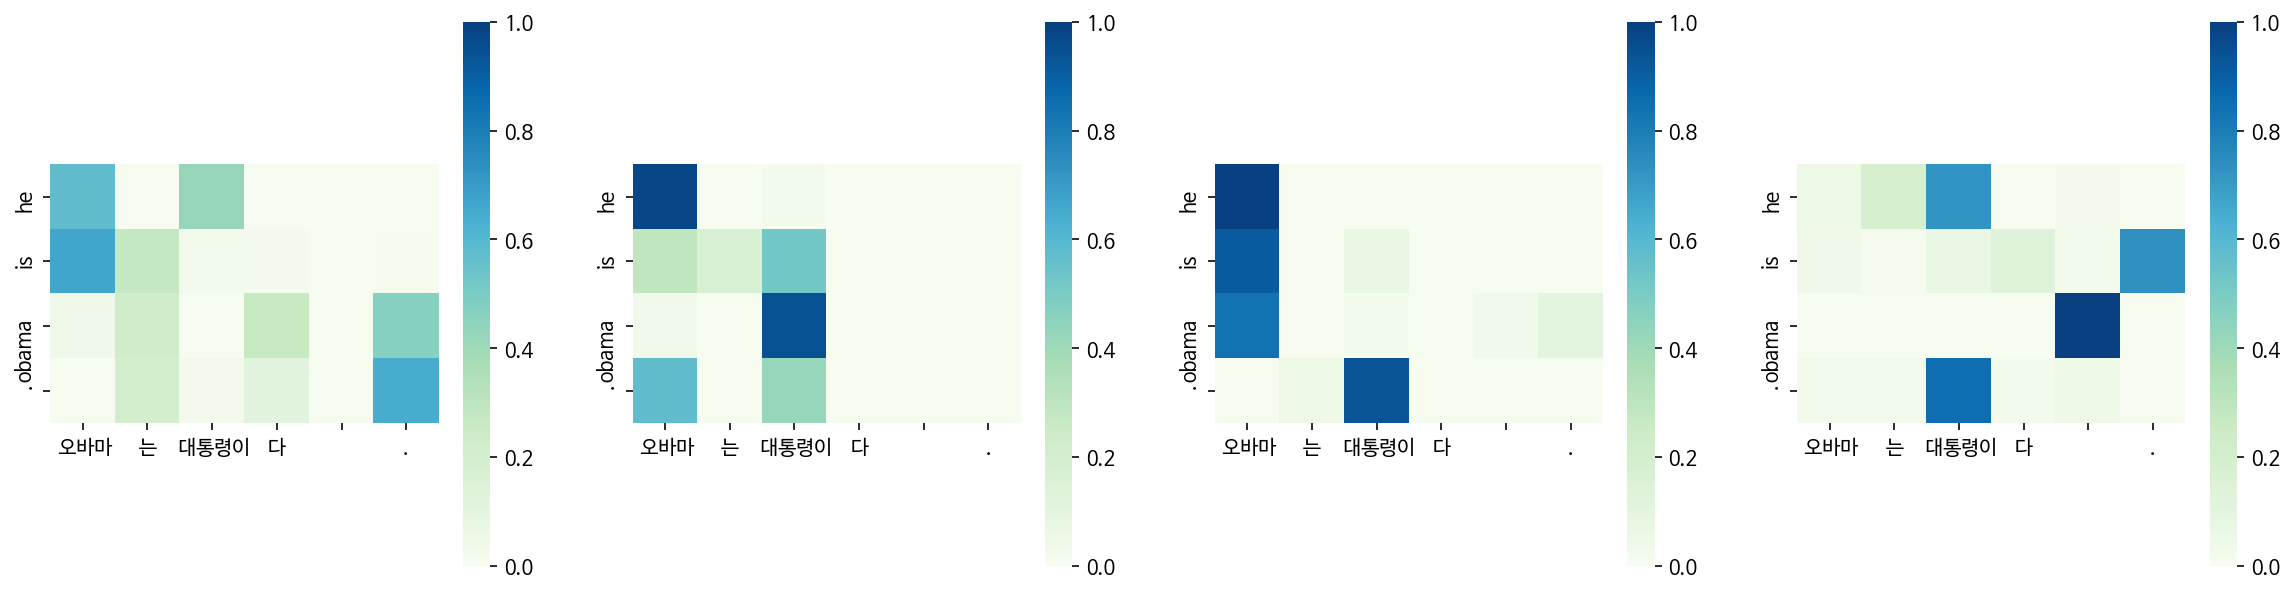

Decoder Self Layer 2


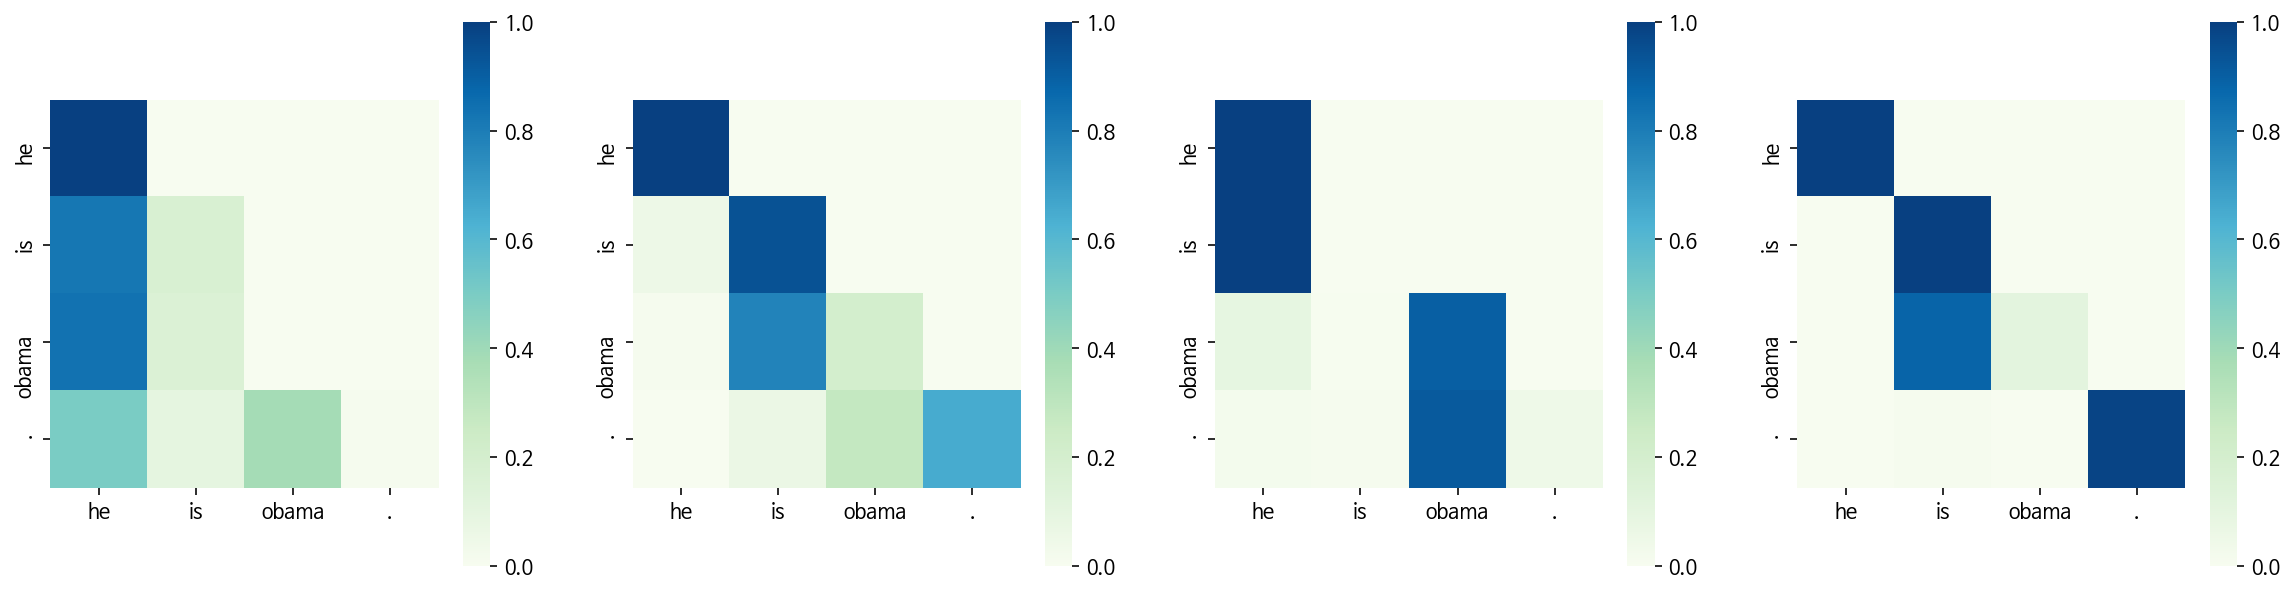

Decoder Src Layer 2


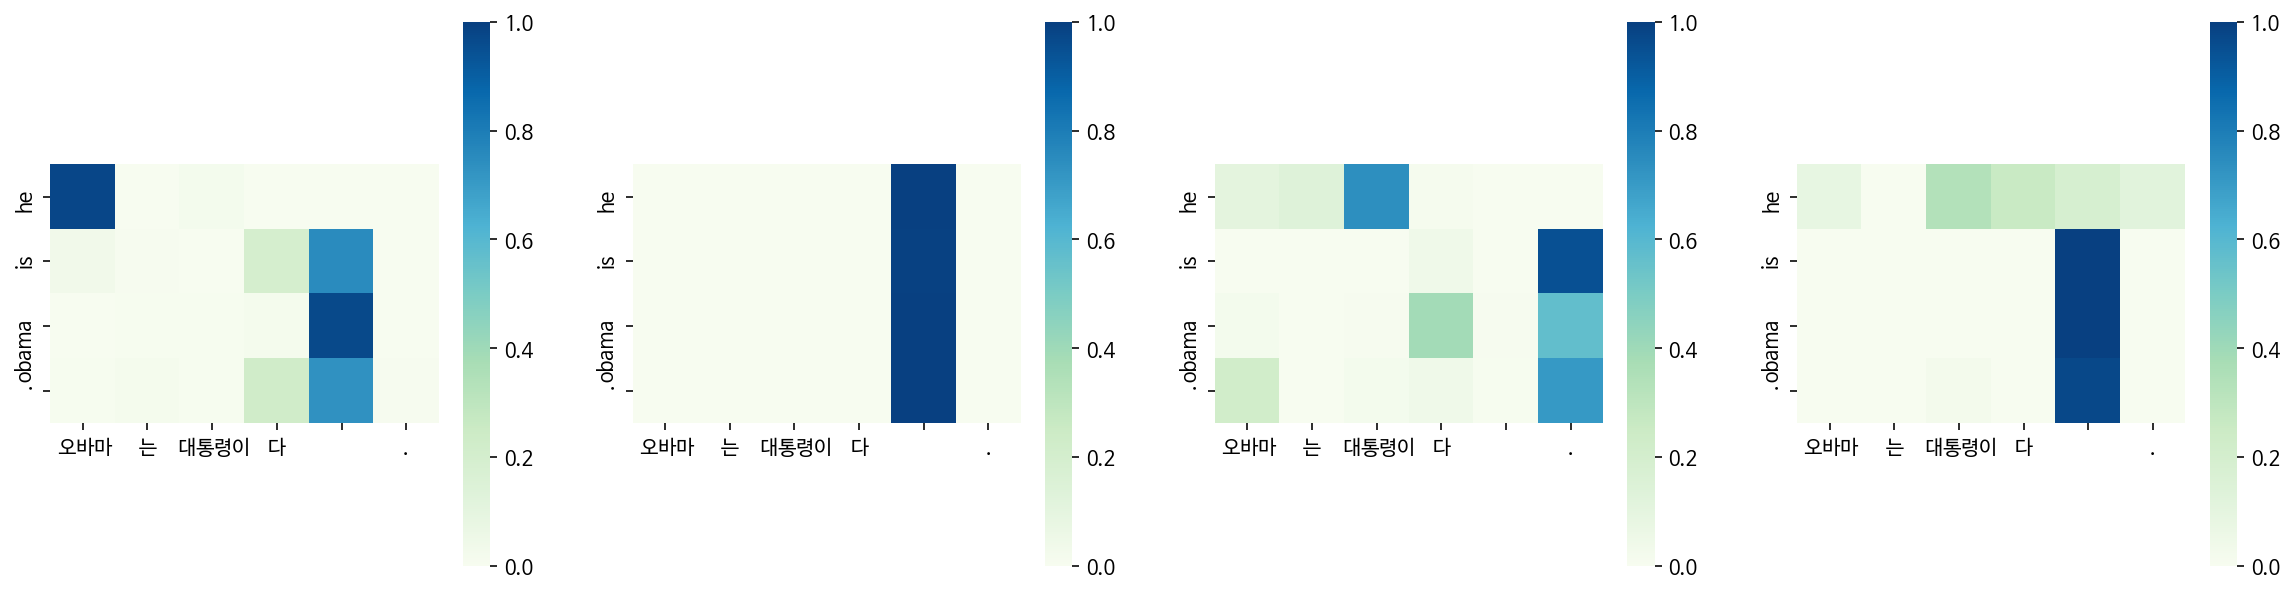

🇰🇷 : 시민들은 도시 속에 산다.
🇺🇸 : the city is known .
🇰🇷 : 커피는 필요 없다.
🇺🇸 : therapy coffee needs coffee .
🇰🇷 : 일곱 명의 사망자가 발생했다.
🇺🇸 : five people were killed monday and six were wounded .


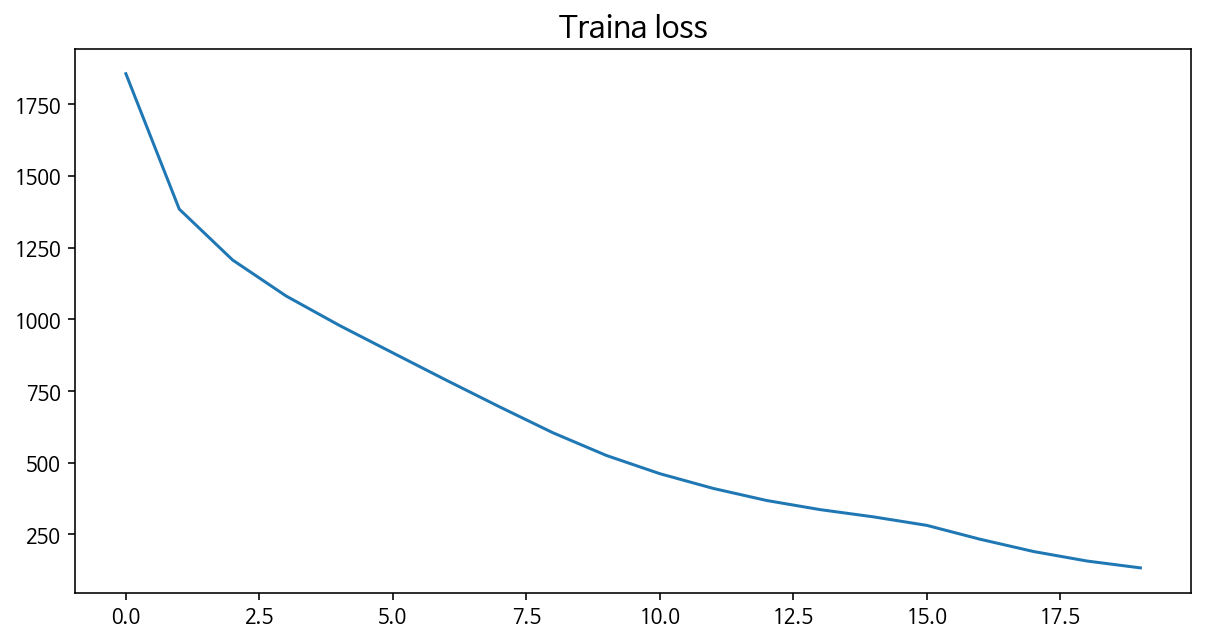

In [40]:
losses_3 = train(transformer_3, optimizer_3, enc_train, dec_train, 
                 ko_tokenizer, en_tokenizer, examples, 20, 256)
show_train_loss(losses_3)

In [44]:
print_result(transformer_3, ko_tokenizer, en_tokenizer, examples,
             n_layers=hyperparameters_3['n_layers'], 
             d_model=hyperparameters_3['d_model'], 
             n_heads=hyperparameters_3['n_heads'], 
             d_ff=hyperparameters_3['d_ff'], 
             dropout=hyperparameters_3['dropout'])

Translations
> 1. he is obama .
> 2. the city is known .
> 3. therapy coffee needs coffee .
> 4. five people were killed monday and six were wounded .

Hyperparameters
> n_layers: 2
> d_model: 512
> n_heads: 8
> d_ff: 2048
> dropout: 0.3
